In [4]:
from generate_data import Data
from evaluate import *
from models import *

from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [5]:
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [6]:
%autosave 120

Autosaving every 120 seconds


# Get the synthetic dataset

In [7]:
%%time
data = Data(layer_size=16, interop_distances=[0,1,2], permutation_intervals=2)

C:\Users\Luna Santos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(


CPU times: total: 3.67 s
Wall time: 3.99 s


In [8]:
%%time
train, val, test = data.get_splits(['1st_interval', 'omit_distances'], [[0, 2]])

train_unshuffled = train.copy()
np.random.shuffle(train)

x_train, y_train = data.get_x_y(train)
x_val, y_val = data.get_x_y(val)
x_test, y_test = data.get_x_y(test)

train_original = data.reverse_encoding(data.get_x_y(train_unshuffled)[0])
val_original = data.reverse_encoding(x_val)
test_original = data.reverse_encoding(x_test)

Number of samples: 1293 train | 662 val | 2648 test
CPU times: total: 45.1 s
Wall time: 46.3 s


#### Peek at unshuffled train data

In [9]:
train_original[:20]

[['.,.,..,._._..__.', 'w__.____._.__,,,', 'c_r,_..,,_..,_,_', 'V'],
 [',,,_,___.,._,___', 'w_,_,,,,.,,,.,__', ',c_r,,____.,,._,', 'V'],
 ['_.,,_,,.,______,', 'w__,_._.,._,,__,', ',,c_r__,,..._,.,', 'V'],
 ['._...__..,,..,_.', 'w.___.,._.__,.._', '._.c,r,,___..__,', 'V'],
 ['._,..,,.__.._.__', 'w..,_..__._,__.,', '.,,_c.r,.._,_,..', 'V'],
 ['.._._,__,_,_.,,,', 'w,,.__.___..___.', ',_._,c.r.,,_,_.,', 'V'],
 ['_,_,,,_.,,.__,__', 'w.,._,__,..,_,.,', '.,,,,_c,r,,_....', 'V'],
 ['_._,..,,.___..,,', '.w,..,_,._._,,_.', 'c.r_,,..,__.,.,,', 'V'],
 ['.,,,,_._,_...._,', '_w._.__._,,__,_,', '.c,r_.,.,,_.,...', 'V'],
 ['...,..,,_.,.._,.', '.w,,_.,.,.,_,_,.', '__c_r,_.,_,.,.._', 'V'],
 ['_.__..,,.,,.__,,', '.w,.,_.,,.,.,..,', '._,c,r.,._,._,._', 'V'],
 ['__,.__.,,._,.__.', ',w.._,.__.,._.._', '.,._c_r__._,.,._', 'V'],
 ['_,_,,__.,,.__,..', ',w_.____.._,__,.', '_.,,,c,r,,...,.,', 'V'],
 ['.,,.,_,.__._._._', '.w,._,._,.__,__.', ',.,.,,c.r,_,..._', 'V'],
 ['....,.,.,,_._.,.', ',,w.._.__..._.._', 'c,r._

In [10]:
pos_train_ratio = get_stats_and_ratio(train_original)

Number of samples by case:
F3 dr:    F2-wu 49 | F2-uw 49 | F2-w 49 | F2-noop 56 | 
F3 cr:    F2-wu 49 | F2-uw 49 | F2-w 49 | F2-noop 56 | 
F3 r:    F2-wu 49 | F2-uw 49 | F2-w 162 | F2-noop 169 | 
F3 noop:    F2-wu 56 | F2-uw 56 | F2-w 169 | F2-noop 177 | 

Positive samples count: 583
Total samples count: 1293
Positive class ratio: 0.4508894044856922


#### Peek at test data

In [11]:
test_original[:15]

[['..___,_._,,,....', '.,_,_,_,,,,uw_,.', '._,.___..._,,_.r', 'R'],
 ['_,_._,._.,.__.,.', '._.,._..,,_,w.,,', '.,._,.__.,_,.___', 'V'],
 [',,_____,.,..,__,', '_._.,,,.__,w_,u,', '__.,,.__..d,.r,,', 'V'],
 ['..,..,_.._,_,...', ',_wu.,,,___,_,_.', ',,_._r.,___.,,_,', 'R'],
 ['.,.__..,,,,_,,,_', ',..__,_._wu.,,_.', '_,,_...,,_.r__..', 'R'],
 ['__,.___.,,__,.,.', ',._._u..w._,_,.,', '__,r,.._,_.,__..', 'R'],
 [',,,__..,.,..__._', '__..,,___.,,.w__', '._.._.,.._.,.,.,', 'V'],
 [',_._,,..,_,___._', ',,_.....,_.,uw..', '..__,.._,_.._,cr', 'V'],
 [',_.,...,__,,._,.', '..._,_.,__.w,__.', '_._.,.,_.,,,c.,r', 'V'],
 ['._,_,,._._..____', '.,___uw...,...,,', ',,..,__r__,,.._,', 'R'],
 ['._,_,,_,_..._.,.', ',_.,..,.___,._,,', '._..,_,,,._,,r..', 'R'],
 ['.,,__..,,,__,_..', '_.,._.,w..u,.,,.', '_...,....r__,.._', 'R'],
 ['.,,...,..__,_.._', '_,..__._____.uw,', '.,._,,..,..,,r..', 'R'],
 ['_.,,,,_._._.__..', ',,_,_,,,._,_..__', '_,._.._,,_,..cr.', 'V'],
 ['_.__,,,_,,..,.,.', ',..,,_.w_._,_.__', ',.,,_

In [12]:
pos_test_ratio = get_stats_and_ratio(test_original)

Number of samples by case:
F3 dr:    F2-wu 155 | F2-uw 172 | F2-w 166 | F2-noop 170 | 
F3 cr:    F2-wu 168 | F2-uw 148 | F2-w 174 | F2-noop 178 | 
F3 r:    F2-wu 174 | F2-uw 173 | F2-w 148 | F2-noop 156 | 
F3 noop:    F2-wu 187 | F2-uw 168 | F2-w 143 | F2-noop 168 | 

Positive samples count: 1159
Total samples count: 2648
Positive class ratio: 0.43768882175226587


#### Peek at val data

In [13]:
val_original[:15]

[[',..._..,_._,._,.', '_,,____w___.___.', ',_.,,,,,__._._.,', 'V'],
 [',__,_,__,.,._..,', '_,,,,.......,_,,', '__.,._,,,_,..__.', 'V'],
 ['_._.__._...._.__', '.__,.__._...__._', '__.__,,.,,r,._..', 'R'],
 [',..,.._,__._._._', ',_._,___.._.,,w,', '._,_._,.,r._.,__', 'R'],
 ['__.,._,,.______,', '.w..._.._.,_..__', ',d.,r_,._,_,.,._', 'D'],
 ['_,,.,_,._,,____.', '___..._,_,,u__w_', '.,_._,._c_,r_,,,', 'V'],
 [',..._,._,....,.,', ',,_,_,.,,...____', '..dr_..,.___,_._', 'D'],
 [',._,_,.,._,_,,.,', '..,,,._..,___._.', ',_,,,,.,_,d..r,,', 'D'],
 ['_,,,.,_.,_,_.,,,', '__,.,_.,u._w,_,_', ',.,,__.,.,_,_._,', 'V'],
 ['_,,_,___._,__,,_', '_,,,,__,_,,.__,,', '.,_,,_...d__r_..', 'D'],
 ['..,._._,.._.,_..', '..,,,._,.,.w.,_.', '_.,.,_.,_,_.._,.', 'V'],
 [',,.,_,,,_._.,..,', ',.,__,.,_w_.__._', '..,,,__...._.,dr', 'D'],
 ['..,,..._,,_.,,..', '..,...,._..__...', ',_..d..r.,_,__.,', 'D'],
 ['.._...._,,_,_.,,', '._w,,....,._,.__', ',cr_,.__.._,_,..', 'V'],
 [',,.__,,__.__..,_', '_.,__...,,_,,_,,', ',.,_,

In [14]:
pos_val_ratio = get_stats_and_ratio(val_original)

Number of samples by case:
F3 dr:    F2-wu 43 | F2-uw 26 | F2-w 45 | F2-noop 56 | 
F3 cr:    F2-wu 30 | F2-uw 50 | F2-w 37 | F2-noop 48 | 
F3 r:    F2-wu 37 | F2-uw 38 | F2-w 29 | F2-noop 36 | 
F3 noop:    F2-wu 39 | F2-uw 58 | F2-w 49 | F2-noop 41 | 

Positive samples count: 267
Total samples count: 662
Positive class ratio: 0.4033232628398791


#### Send label arrays to device

In [15]:

label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

y_trainP = y_train


y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)


#### Get data in normal format (same as CNN format)

In [16]:
x_train_normal = data.to_conv_format(x_train)
x_val_normal = data.to_conv_format(x_val)
x_test_normal = data.to_conv_format(x_test)
for i in range(len(x_train_normal)):
    x_train_normal[i] = x_train_normal[i].to(device)
    x_val_normal[i] = x_val_normal[i].to(device)
    x_test_normal[i] = x_test_normal[i].to(device)

In [17]:
x_train_normal[0].shape

torch.Size([1293, 128])

#### Get data in convolutional format, send to device

In [18]:
x_train_cnn = data.to_conv_format(x_train, padding_left_size=2, padding_right_size=2)
x_val_cnn = data.to_conv_format(x_val, padding_left_size=2, padding_right_size=2)
x_test_cnn = data.to_conv_format(x_test, padding_left_size=2, padding_right_size=2)
for i in range(len(x_train_cnn)):
    x_train_cnn[i] = x_train_cnn[i].to(device)
    x_val_cnn[i] = x_val_cnn[i].to(device)
    x_test_cnn[i] = x_test_cnn[i].to(device)

In [19]:
x_train_cnn[0].shape

torch.Size([1293, 160])

#### Get data in LSTM format, send to device

In [20]:
x_train_lstm = data.to_lstm_format(x_train, padding_left_size=2, padding_right_size=0)
x_val_lstm = data.to_lstm_format(x_val, padding_left_size=0, padding_right_size=2)
x_test_lstm = data.to_lstm_format(x_test, padding_left_size=0, padding_right_size=2)
for i in range(len(x_train_lstm)):
    x_train_lstm[i] = x_train_lstm[i].to(device)
    x_val_lstm[i] = x_val_lstm[i].to(device)
    x_test_lstm[i] = x_test_lstm[i].to(device)

In [21]:
x_train_lstm[0].shape

torch.Size([1293, 18, 8])

### Define training parameters

In [22]:
num_experiments = 20
epochs = 200
early_stopping_limit = 100

experiment_name = "f2_f4_redo"

### Define training procedure for each model

In [23]:
def train_models(constructor, x_train, x_val, x_test, weight_decay, *argv):
    accuracies = [] #lista con la precisión de cada modelo en el cjto de prueba
    precisions = []
    recalls = []
    f1_scores = []
    wrong_preds = []#lista con las predicciones incorrectas del modelo en el cjto de prueba
    best_accuracy = 0
    
    #listas de listas de cada modelo durante el entrenamiento y prueba
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for i in range(num_experiments):
        model = constructor(*argv)
        model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), weight_decay=weight_decay)

        train_losses.append([])
        val_losses.append([])
        train_accs.append([])
        val_accs.append([])
        
        best_acc = 0

        early_stopping_cnt = 0

        for epoch in range(1, epochs + 1):
            train_loss, train_acc = train_epoch(model, x_train, y_train, criterion, optimizer, epoch, 10, verbose=False)
            val_loss, val_acc = eval_epoch(model, x_val, y_val, criterion, 'Validation', verbose=False)

            
            train_losses[-1].append(train_loss)
            val_losses[-1].append(val_loss)
            train_accs[-1].append(train_acc)
            val_accs[-1].append(val_acc)
            
            model_name = constructor.__name__[:constructor.__name__.find('_')]
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), f'./temp/{model_name}_model_TEMP_' + experiment_name)    
                early_stopping_cnt = 0
            else:
                early_stopping_cnt += 1

            if early_stopping_cnt >= early_stopping_limit:
                break


        model.load_state_dict(torch.load(f'./temp/{model_name}_model_TEMP_' + experiment_name))

        accuracies.append(get_accuracy_by_cases(model, x_test, y_test, test_original)) #Se evalúa el modelo en el conjunto de prueba 
        precisions.append(get_precision(model, x_test, y_test, test_original))
        recalls.append(get_recall(model, x_test, y_test, test_original))
        f1_scores.append(get_f1(precisions[-1], recalls[-1]))        
        
        wrong_preds.append(get_wrong_predictions(model, x_test, y_test, test_original))

        if accuracies[-1]['Overall'] > best_accuracy:
            torch.save(model.state_dict(), f'./bestmodels/best_{model_name}_model_' + experiment_name)    
            best_accuracy = accuracies[-1]['Overall']

        print(i + 1, "/", num_experiments, "models trained | METRICS:")
        print("Accuracy ", accuracies[-1]['Overall'])
        print("Precision ", precisions[-1]['Overall'])
        print("Recalls ", recalls[-1]['Overall'])
        print("F1_scores ", f1_scores[-1]['Overall'])
        print("---------------------------------------------------------------------")
        
    return accuracies, precisions, recalls, f1_scores,  wrong_preds, [train_losses, val_losses, train_accs, val_accs]

# Train models

In [24]:
%%time
cnn_accuracies, cnn_precisions, cnn_recall, cnn_f1_scores, cnn_wrong_preds, cnn_epoch_stats = train_models(CNN_Model, x_train_cnn, x_val_cnn, x_test_cnn, 0.005, data, 32, 64, 4, -1, 'keras')


1 / 20 models trained | METRICS:
Accuracy  0.94297583081571
Precision  0.9769817073170732
Recalls  0.7805232558139534
F1_scores  0.8677721645886997
---------------------------------------------------------------------
2 / 20 models trained | METRICS:
Accuracy  0.7564199395770392
Precision  0.8107868022751765
Recalls  0.8180435597482313
F1_scores  0.8143990158755882
---------------------------------------------------------------------
3 / 20 models trained | METRICS:
Accuracy  0.7088368580060423
Precision  0.3342494045086686
Recalls  0.42363997528212527
F1_scores  0.37367302733072943
---------------------------------------------------------------------
4 / 20 models trained | METRICS:
Accuracy  0.6314199395770392
Precision  0.814326960859686
Recalls  0.7469944320364846
F1_scores  0.7792088270705327
---------------------------------------------------------------------
5 / 20 models trained | METRICS:
Accuracy  0.702416918429003
Precision  0.3458330129198337
Recalls  0.4080342377640846
F1

In [25]:
%%time
lstm_accuracies, lstm_precisions, lstm_recall, lstm_f1_scores, lstm_wrong_preds, lstm_epoch_stats = train_models(LSTM_Model, x_train_lstm, x_val_lstm, x_test_lstm, 0.0001, data, 16, 32, 8, 'keras')

1 / 20 models trained | METRICS:
Accuracy  0.8987915407854985
Precision  0.6685834683521197
Recalls  0.7027239048111913
F1_scores  0.6852287018464946
---------------------------------------------------------------------
2 / 20 models trained | METRICS:
Accuracy  0.9399546827794562
Precision  0.9190910571594256
Recalls  0.8850360391234718
F1_scores  0.901742133908544
---------------------------------------------------------------------
3 / 20 models trained | METRICS:
Accuracy  0.9169184290030211
Precision  0.9512897547748792
Recalls  0.8912870337674228
F1_scores  0.9203114128637311
---------------------------------------------------------------------
4 / 20 models trained | METRICS:
Accuracy  0.9675226586102719
Precision  0.9720727528504491
Recalls  0.9687828315013128
F1_scores  0.9704250038224942
---------------------------------------------------------------------
5 / 20 models trained | METRICS:
Accuracy  0.9282477341389728
Precision  0.8837402046793337
Recalls  0.9225823059337273
F

In [26]:
%%time
deepset_accuracies, deepset_precisions, deepset_recall, deepset_f1_scores,deepset_wrong_preds, deepset_epoch_stats = train_models(DEEPSET_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 128, 32, 8, 'keras')

1 / 20 models trained | METRICS:
Accuracy  0.6846676737160121
Precision  0.7606930733139631
Recalls  0.6134895675341353
F1_scores  0.6792070438112626
---------------------------------------------------------------------
2 / 20 models trained | METRICS:
Accuracy  0.68202416918429
Precision  0.7511287045254956
Recalls  0.5587359503262519
F1_scores  0.6408030157709379
---------------------------------------------------------------------
3 / 20 models trained | METRICS:
Accuracy  0.6744712990936556
Precision  0.7332179753207465
Recalls  0.5815494288863077
F1_scores  0.6486356346111598
---------------------------------------------------------------------
4 / 20 models trained | METRICS:
Accuracy  0.6839123867069486
Precision  0.8260590030927843
Recalls  0.5820938226588982
F1_scores  0.6829426949385262
---------------------------------------------------------------------
5 / 20 models trained | METRICS:
Accuracy  0.6858006042296072
Precision  0.7169988545296854
Recalls  0.6067874633053834
F1

In [27]:
%%time
deepsetv2_accuracies, deepsetv2_precisions, deepsetv2_recall, deepsetv2_f1_scores, deepsetv2_wrong_preds, deepsetv2_epoch_stats = train_models(DEEPSETV2_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 32, 8, 'keras')

1 / 20 models trained | METRICS:
Accuracy  0.7152567975830816
Precision  0.8408743837390058
Recalls  0.6723364149528841
F1_scores  0.7472197119892637
---------------------------------------------------------------------
2 / 20 models trained | METRICS:
Accuracy  0.6325528700906344
Precision  0.40147593591205843
Recalls  0.3859353902924546
F1_scores  0.39355230706703215
---------------------------------------------------------------------
3 / 20 models trained | METRICS:
Accuracy  0.7046827794561934
Precision  0.7260146813206266
Recalls  0.6665614150022362
F1_scores  0.6950189286909555
---------------------------------------------------------------------
4 / 20 models trained | METRICS:
Accuracy  0.6635196374622356
Precision  0.6760911847303444
Recalls  0.5429623966316158
F1_scores  0.6022575145426683
---------------------------------------------------------------------
5 / 20 models trained | METRICS:
Accuracy  0.7043051359516617
Precision  0.7316422075292557
Recalls  0.673179873914521

In [28]:
%%time
feedforward_accuracies, feedforward_precisions, feedforward_recall, feedforward_f1_scores, feedforward_wrong_preds, feedforward_epoch_stats = train_models(FEEDFORWARD_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 128, 32, 8, 'keras')

1 / 20 models trained | METRICS:
Accuracy  0.6918429003021148
Precision  0.7728153294110365
Recalls  0.6187810088984602
F1_scores  0.6872732214947846
---------------------------------------------------------------------
2 / 20 models trained | METRICS:
Accuracy  0.6808912386706949
Precision  0.7679554645113065
Recalls  0.5892529555682271
F1_scores  0.666839404343719
---------------------------------------------------------------------
3 / 20 models trained | METRICS:
Accuracy  0.6816465256797583
Precision  0.7591394635492645
Recalls  0.5746328335269282
F1_scores  0.6541243388210909
---------------------------------------------------------------------
4 / 20 models trained | METRICS:
Accuracy  0.699773413897281
Precision  0.8118786590078164
Recalls  0.638646234036082
F1_scores  0.7149180969676946
---------------------------------------------------------------------
5 / 20 models trained | METRICS:
Accuracy  0.6812688821752266
Precision  0.7648305771025169
Recalls  0.5962400752340788
F1_

# Evaluation

In [42]:
all_accuracies = [cnn_accuracies, lstm_accuracies, deepset_accuracies, deepsetv2_accuracies, feedforward_accuracies]
all_precisions = [cnn_precisions, lstm_precisions, deepset_precisions, deepsetv2_precisions, feedforward_precisions]
all_recalls = [cnn_recall, lstm_recall, deepset_recall, deepsetv2_recall, feedforward_recall]
all_f1_scores = [cnn_f1_scores, lstm_f1_scores, deepset_f1_scores, deepsetv2_f1_scores, feedforward_f1_scores]

model_names = ['CNN', 'LSTM', 'DeepSet(like in paper)', 'DeepSet(sum at start)', 'Feedforward']

get_summary_df(model_names, all_accuracies, all_precisions, all_recalls, all_f1_scores)

                   Modelo  Accuracy  Precision    Recall  F1-score  \
0                     CNN  0.956571   0.906121  0.913928  0.910008   
1                    LSTM  0.978097   0.962923  0.980775  0.971767   
2  DeepSet(like in paper)  0.699773   0.848224  0.614934  0.712981   
3   DeepSet(sum at start)  0.723565   0.824807  0.669785  0.739256   
4             Feedforward  0.706949   0.777446  0.642662  0.703658   

   Precision clase A  Recall clase A  Precision clase D  Recall clase D  \
0           0.771429        0.784884           0.870466        0.898396   
1           0.876289        0.988372           1.000000        1.000000   
2           0.880952        0.215116           0.938650        0.956250   
3           0.875000        0.366279           0.929825        0.952096   
4           0.753846        0.284884           0.921212        0.950000   

   Precision clase R  Recall clase R  Precision clase V  Recall clase V  
0           1.000000        1.000000           0.98259

## Accuracies per CNN model

In [30]:
get_stats_per_model_multiclass(cnn_accuracies, cnn_precisions, cnn_recall, cnn_f1_scores, ['CNN #' + str(i) for i in range(len(cnn_accuracies))])

,Modelo,Accuracy,F1-score,Precision_Overall,Recall_Overall,Precision_A,Precision_D,Precision_R,Precision_V,Recall_A,Recall_D,Recall_R,Recall_V
0,CNN #0,0.942976,0.867772,0.976982,0.780523,1.000000,1.000000,1.000000,0.907927,0.122093,1.000000,1.000000,1.000000
1,CNN #1,0.756420,0.814399,0.810787,0.818044,0.738255,1.000000,0.526699,0.978193,0.639535,1.000000,1.000000,0.632639
2,CNN #2,0.708837,0.373673,0.334249,0.423640,0.000000,0.000000,0.489279,0.847719,0.000000,0.000000,0.771121,0.923439
3,CNN #3,0.631420,0.779209,0.814327,0.746994,0.853211,1.000000,0.404097,1.000000,0.540698,1.000000,1.000000,0.447280
4,CNN #4,0.702417,0.374368,0.345833,0.408034,0.000000,0.000000,0.670197,0.713135,0.000000,0.000000,0.680492,0.951645
5,CNN #5,0.714124,0.394009,0.348353,0.453439,0.000000,0.000000,0.530802,0.862611,0.000000,0.000000,0.966206,0.847549
6,CNN #6,0.918051,0.870229,0.876452,0.864095,0.844595,0.784038,0.897931,0.979244,0.726744,0.784038,1.000000,0.945598
7,CNN #7,0.663142,0.333251,0.304581,0.367880,0.000000,0.000000,0.498525,0.719797,0.000000,0.000000,0.519201,0.952317
8,CNN #8,0.956571,0.910008,0.906121,0.913928,0.771429,0.870466,1.000000,0.982591,0.784884,0.898396,1.000000,0.972433
9,CNN #9,0.830438,0.790902,0.893971,0.709143,1.000000,1.000000,0.658907,0.916976,0.005814,1.000000,1.000000,0.830759


## Accuracies per LSTM model

In [31]:
get_stats_per_model_multiclass(lstm_accuracies, lstm_precisions,lstm_recall, lstm_f1_scores, ['LSTM #' + str(i) for i in range(len(lstm_accuracies))])

,Modelo,Accuracy,F1-score,Precision_Overall,Recall_Overall,Precision_A,Precision_D,Precision_R,Precision_V,Recall_A,Recall_D,Recall_R,Recall_V
0,LSTM #0,0.898792,0.685229,0.668583,0.702724,0.000000,0.790476,0.991749,0.892109,0.000000,0.887701,0.923195,1.000000
1,LSTM #1,0.939955,0.901742,0.919091,0.885036,0.787234,0.993958,0.961538,0.933634,0.645349,1.000000,0.921659,0.973136
2,LSTM #2,0.916918,0.920311,0.951290,0.891287,0.961538,0.973913,0.989540,0.880168,0.872093,0.973913,0.726575,0.992568
3,LSTM #3,0.967523,0.970425,0.972073,0.968783,0.949438,1.000000,0.981544,0.957309,0.982558,1.000000,0.898618,0.993956
4,LSTM #4,0.928248,0.902744,0.883740,0.922582,0.736842,0.905405,0.932907,0.959806,0.895349,0.951705,0.906832,0.936444
5,LSTM #5,0.879154,0.698283,0.697069,0.699502,0.000000,1.000000,0.954380,0.833896,0.000000,1.000000,0.803379,0.994627
6,LSTM #6,0.920317,0.907854,0.893811,0.922346,0.780220,0.993080,0.839437,0.962509,0.825581,1.000000,0.915515,0.948287
7,LSTM #7,0.978097,0.971767,0.962923,0.980775,0.876289,1.000000,0.996779,0.978624,0.988372,1.000000,0.950845,0.983882
8,LSTM #8,0.941465,0.949021,0.957383,0.940803,0.959064,1.000000,0.943563,0.926906,0.953488,1.000000,0.821813,0.987911
9,LSTM #9,0.914275,0.923687,0.949594,0.899157,0.962264,1.000000,0.954918,0.881194,0.889535,1.000000,0.715822,0.991269


## Accuracies per DeepSets V1 model

In [32]:
get_stats_per_model_multiclass(deepset_accuracies, deepset_precisions,deepset_recall, deepset_f1_scores, ['DEEPSETS #' + str(i) for i in range(len(deepset_accuracies))])

,Modelo,Accuracy,F1-score,Precision_Overall,Recall_Overall,Precision_A,Precision_D,Precision_R,Precision_V,Recall_A,Recall_D,Recall_R,Recall_V
0,DEEPSETS #0,0.684668,0.679207,0.760693,0.613490,0.685714,0.884848,0.817021,0.655188,0.279070,0.912500,0.294931,0.967458
1,DEEPSETS #1,0.682024,0.640803,0.751129,0.558736,0.642857,0.821229,0.889401,0.651028,0.052326,0.896341,0.296467,0.989810
2,DEEPSETS #2,0.674471,0.648636,0.733218,0.581549,0.673913,0.797386,0.810127,0.651447,0.180233,0.871429,0.294931,0.979606
3,DEEPSETS #3,0.683912,0.682943,0.826059,0.582094,0.869565,0.910959,0.874419,0.649293,0.116279,0.930070,0.290123,0.991903
4,DEEPSETS #4,0.685801,0.657305,0.716999,0.606787,0.525641,0.832370,0.847162,0.662823,0.238372,0.917197,0.298003,0.973577
5,DEEPSETS #5,0.677492,0.647965,0.740365,0.576070,0.674419,0.800000,0.835498,0.651543,0.168605,0.860759,0.297381,0.977536
6,DEEPSETS #6,0.699773,0.712981,0.848224,0.614934,0.880952,0.938650,0.914692,0.658602,0.215116,0.956250,0.296467,0.991903
7,DEEPSETS #7,0.669184,0.625840,0.688941,0.573328,0.517241,0.756579,0.831897,0.650045,0.174419,0.845588,0.296467,0.976839
8,DEEPSETS #8,0.679381,0.646213,0.769941,0.556746,0.800000,0.750000,0.876712,0.653052,0.116279,0.819876,0.296296,0.994532
9,DEEPSETS #9,0.671073,0.606344,0.679953,0.547116,0.500000,0.724868,0.843318,0.651625,0.075581,0.845679,0.281538,0.985666


## Accuracies per DeepSets V2 model

In [33]:
get_stats_per_model_multiclass(deepsetv2_accuracies, deepsetv2_precisions,deepsetv2_recall, deepsetv2_f1_scores, ['DEESETS V2 #' + str(i) for i in range(len(lstm_accuracies))])

,Modelo,Accuracy,F1-score,Precision_Overall,Recall_Overall,Precision_A,Precision_D,Precision_R,Precision_V,Recall_A,Recall_D,Recall_R,Recall_V
0,DEESETS V2 #0,0.715257,0.747220,0.840874,0.672336,0.984375,0.948052,0.746356,0.684715,0.366279,0.966887,0.393241,0.962938
1,DEESETS V2 #1,0.632553,0.393552,0.401476,0.385935,0.247475,0.000000,0.699275,0.659154,0.284884,0.000000,0.296467,0.962391
2,DEESETS V2 #2,0.704683,0.695019,0.726015,0.666561,0.558140,0.892045,0.766467,0.687407,0.418605,0.918129,0.393241,0.936271
3,DEESETS V2 #3,0.663520,0.602258,0.676091,0.542962,0.756098,0.603239,0.678201,0.666828,0.180233,0.726829,0.301075,0.963712
4,DEESETS V2 #4,0.704305,0.701195,0.731642,0.673180,0.549296,0.898876,0.794212,0.684184,0.453488,0.924855,0.379416,0.934959
5,DEESETS V2 #5,0.634063,0.514480,0.530918,0.499029,0.300000,0.625899,0.545455,0.652316,0.034884,0.707317,0.295840,0.958076
6,DEESETS V2 #6,0.606873,0.369773,0.343054,0.401007,0.000000,0.323529,0.391304,0.657382,0.000000,0.366667,0.281250,0.956111
7,DEESETS V2 #7,0.685045,0.674413,0.749445,0.613037,0.706897,0.836257,0.794239,0.660386,0.238372,0.947020,0.296467,0.970290
8,DEESETS V2 #8,0.723565,0.739256,0.824807,0.669785,0.875000,0.929825,0.805112,0.689293,0.366279,0.952096,0.387097,0.973666
9,DEESETS V2 #9,0.604985,0.345548,0.387894,0.311538,0.500000,0.000000,0.402105,0.649470,0.005814,0.000000,0.293395,0.946944


## Accuracies per FeedForward model

In [34]:
get_stats_per_model_multiclass(feedforward_accuracies, feedforward_precisions,feedforward_recall, feedforward_f1_scores, ['FEED FORWARD #' + str(i) for i in range(len(lstm_accuracies))])

,Modelo,Accuracy,F1-score,Precision_Overall,Recall_Overall,Precision_A,Precision_D,Precision_R,Precision_V,Recall_A,Recall_D,Recall_R,Recall_V
0,FEED FORWARD #0,0.691843,0.687273,0.772815,0.618781,0.681818,0.904192,0.845133,0.660119,0.261628,0.943750,0.293395,0.976351
1,FEED FORWARD #1,0.680891,0.666839,0.767955,0.589253,0.774194,0.780899,0.865471,0.651259,0.279070,0.803468,0.296467,0.978007
2,FEED FORWARD #2,0.681647,0.654124,0.759139,0.574633,0.777778,0.741573,0.859729,0.657479,0.162791,0.851613,0.292308,0.991820
3,FEED FORWARD #3,0.699773,0.714918,0.811879,0.638646,0.791667,0.924855,0.869369,0.661623,0.331395,0.952381,0.296467,0.974342
4,FEED FORWARD #4,0.681269,0.670094,0.764831,0.596240,0.672414,0.853503,0.883721,0.649684,0.226744,0.887417,0.291859,0.978940
5,FEED FORWARD #5,0.681269,0.668058,0.774154,0.587537,0.775000,0.833333,0.834783,0.653501,0.180233,0.886525,0.294931,0.988459
6,FEED FORWARD #6,0.670695,0.639299,0.723211,0.572834,0.650000,0.831250,0.762846,0.648747,0.151163,0.875000,0.296467,0.968707
7,FEED FORWARD #7,0.679003,0.648160,0.743691,0.574379,0.698413,0.734375,0.889401,0.652574,0.255814,0.766304,0.303459,0.971937
8,FEED FORWARD #8,0.680136,0.676847,0.777061,0.599529,0.674419,0.929688,0.855204,0.648936,0.168605,0.952000,0.290323,0.987188
9,FEED FORWARD #9,0.671450,0.618866,0.702892,0.552784,0.566667,0.778443,0.816594,0.649865,0.098837,0.838710,0.287250,0.986339


# Training evolution

### CNN

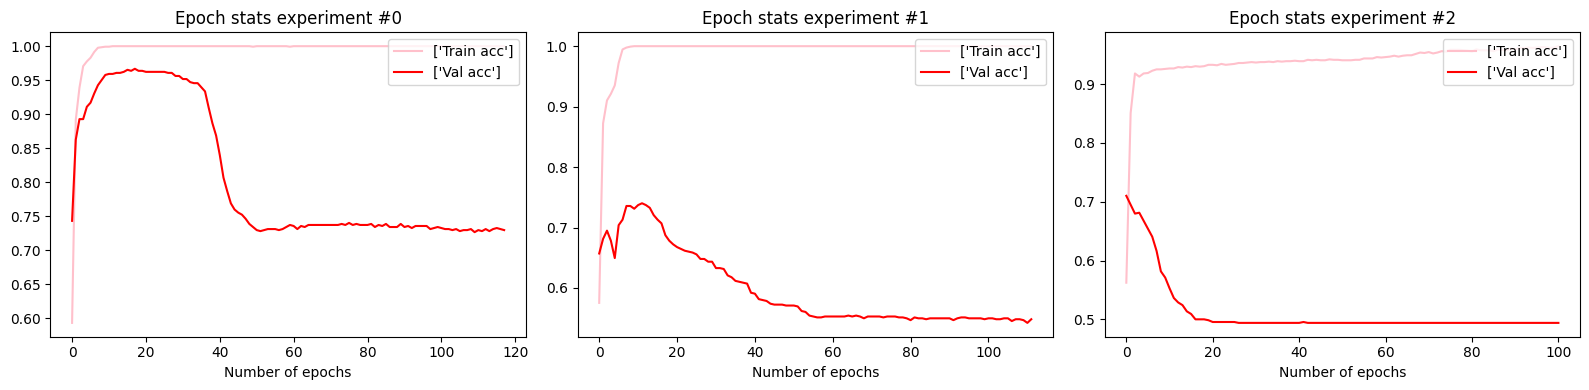

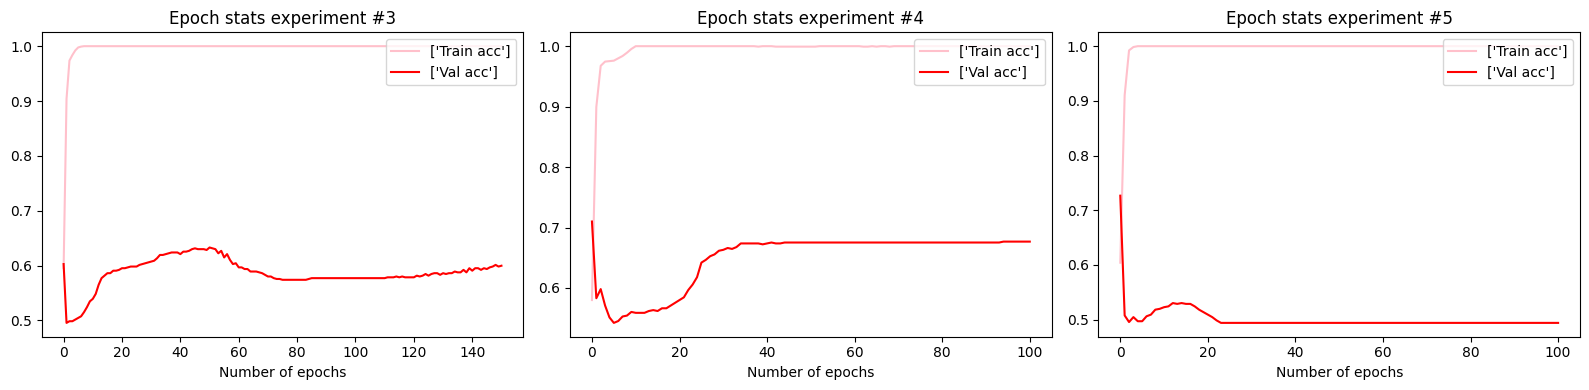

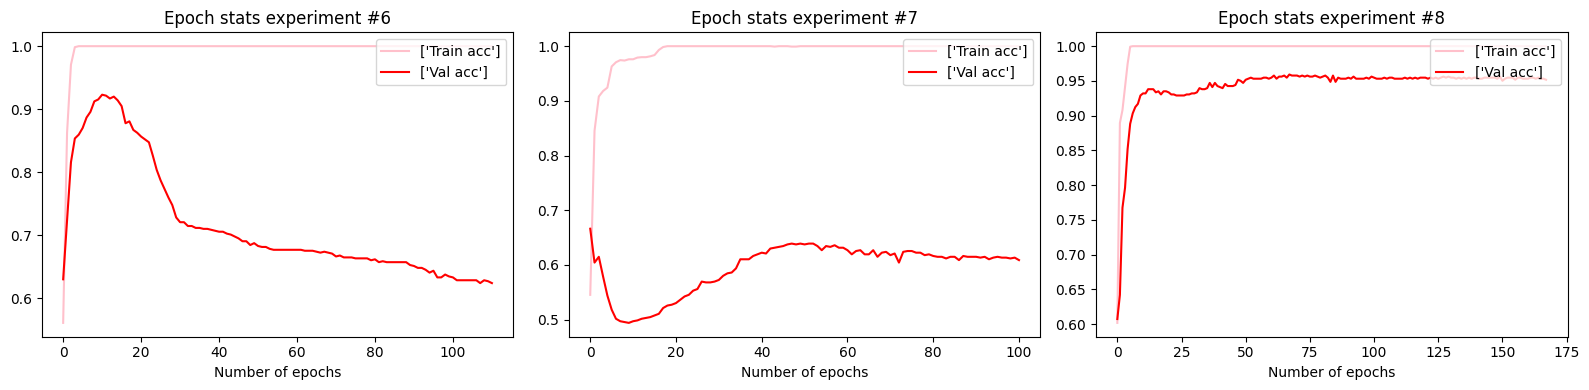

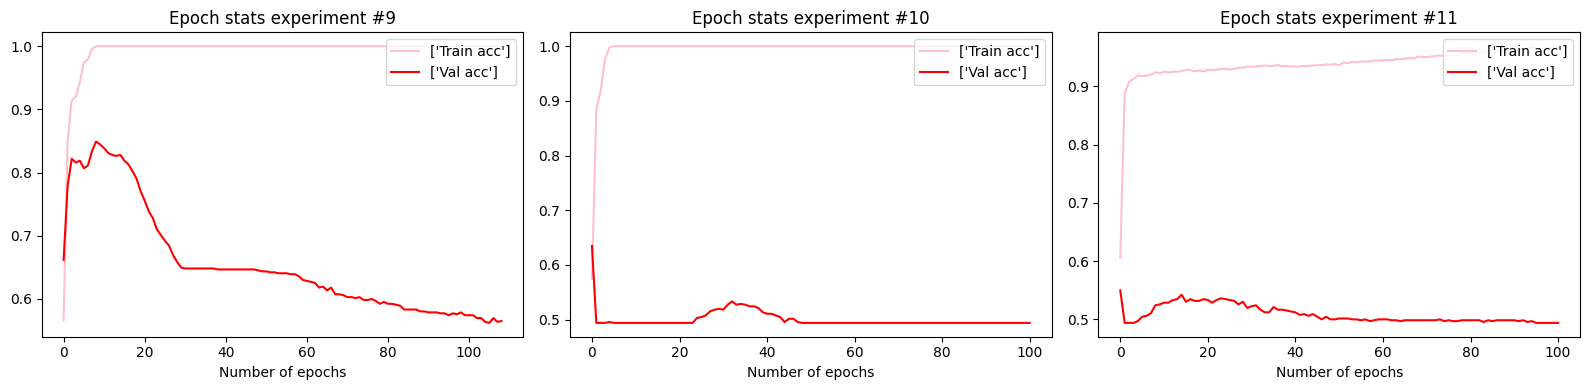

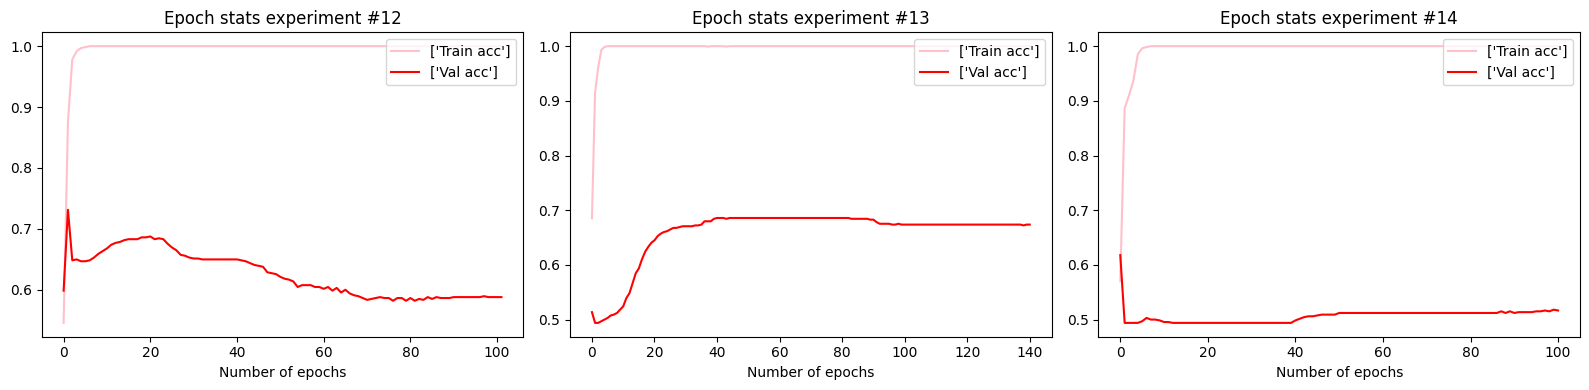

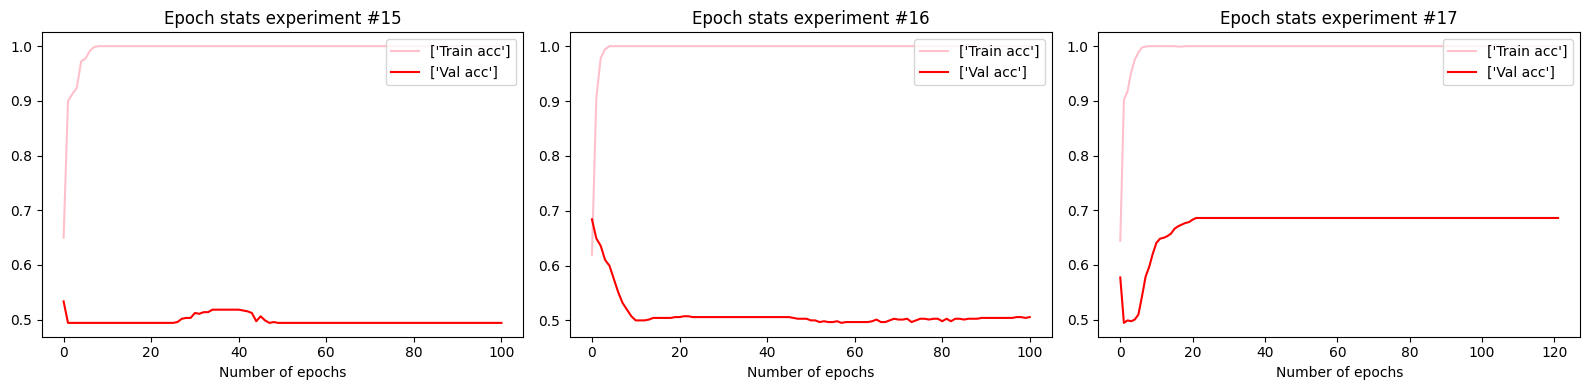

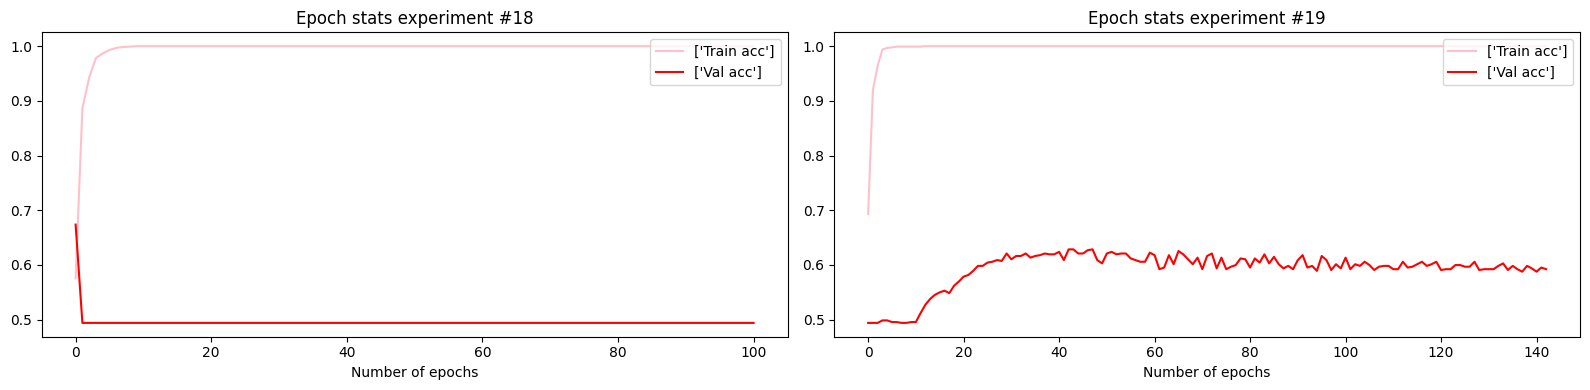

In [35]:
display_epochs_stats(cnn_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### LSTM

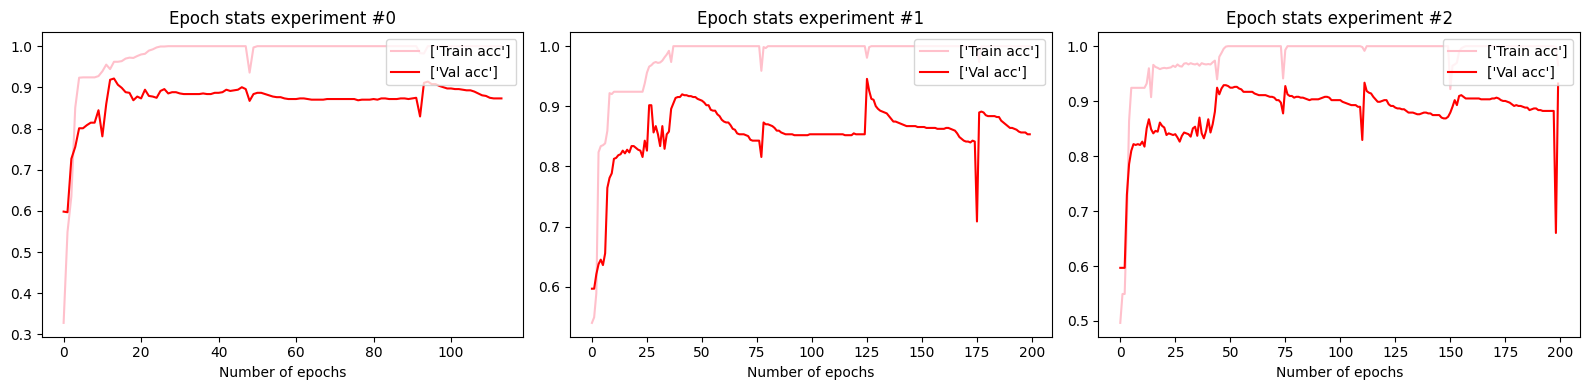

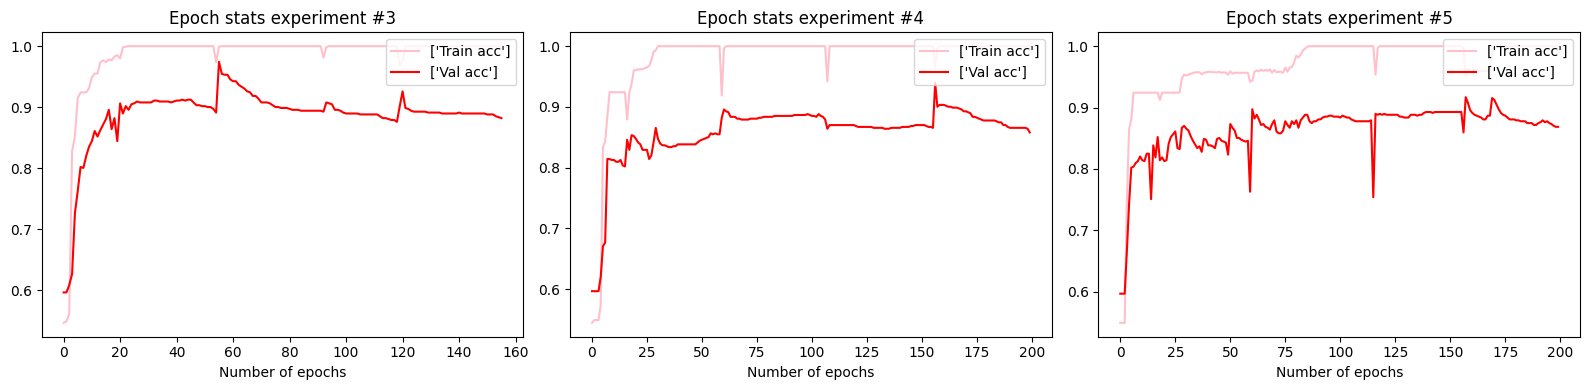

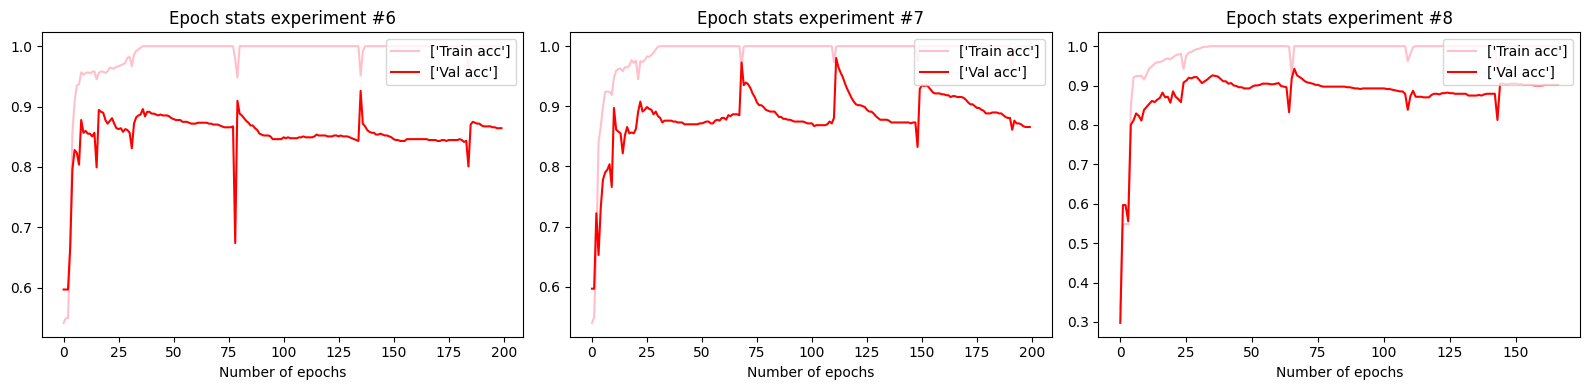

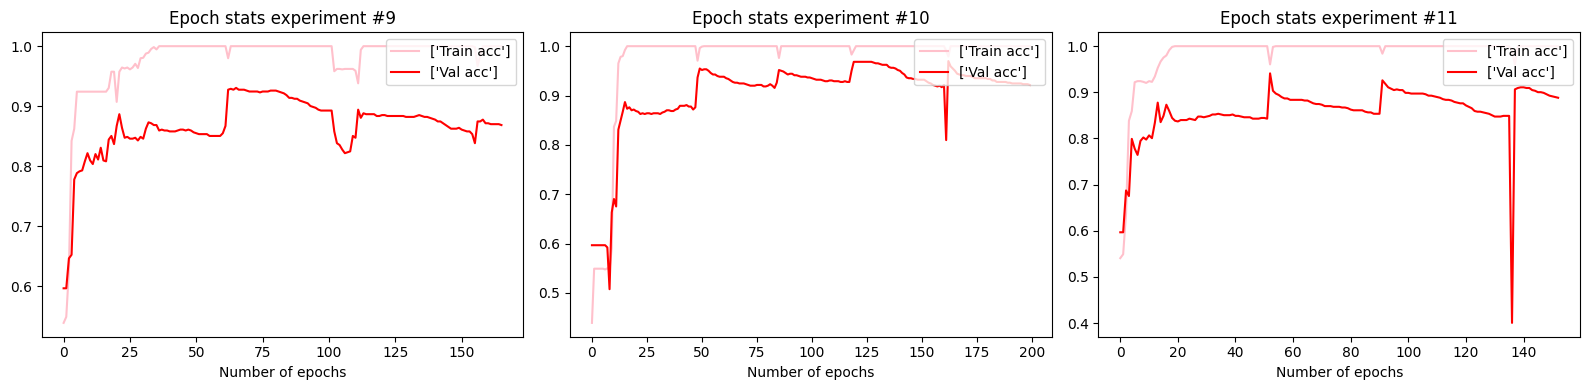

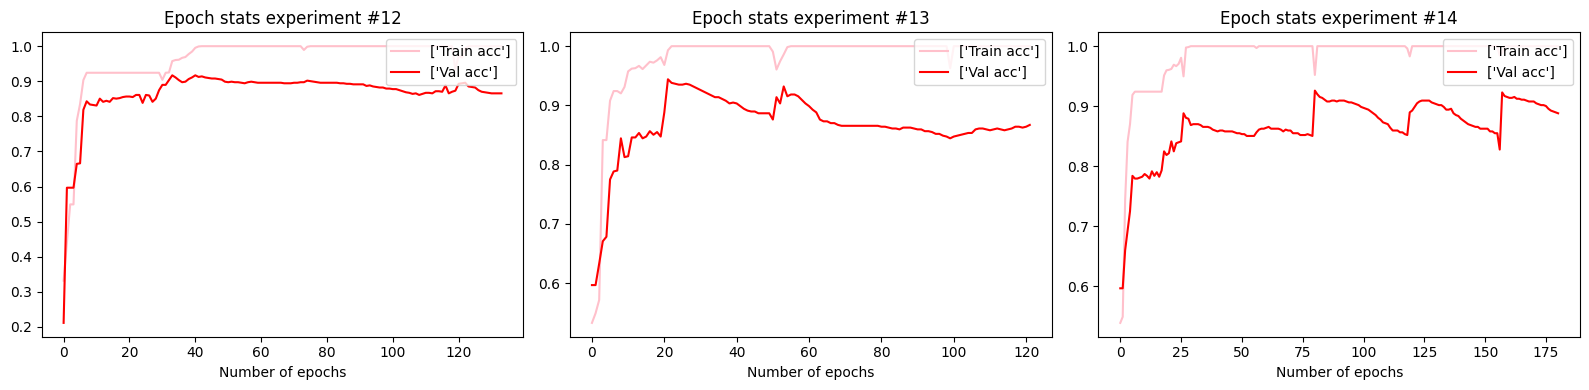

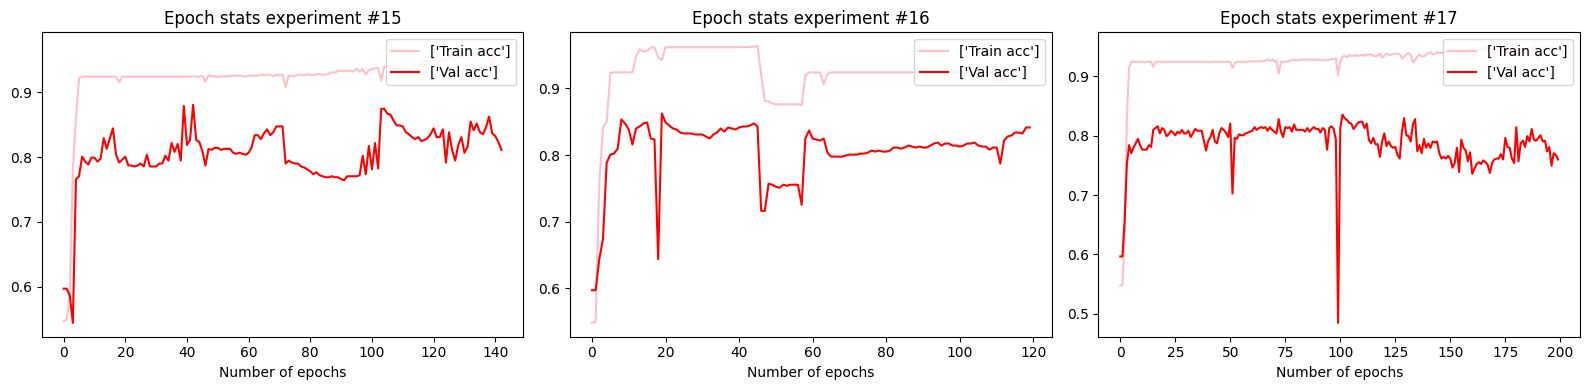

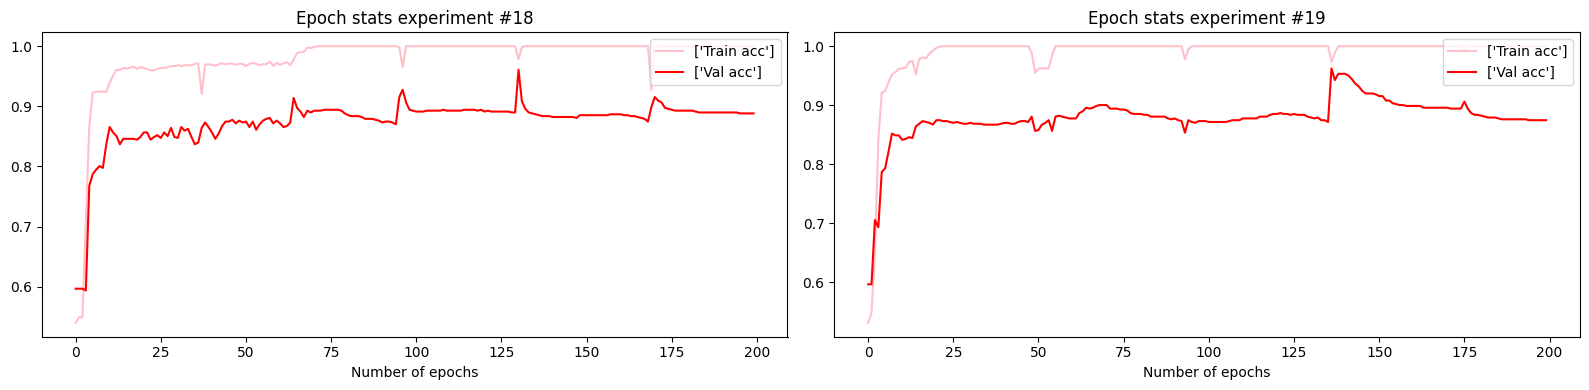

In [41]:
display_epochs_stats(lstm_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### DeepSets V1

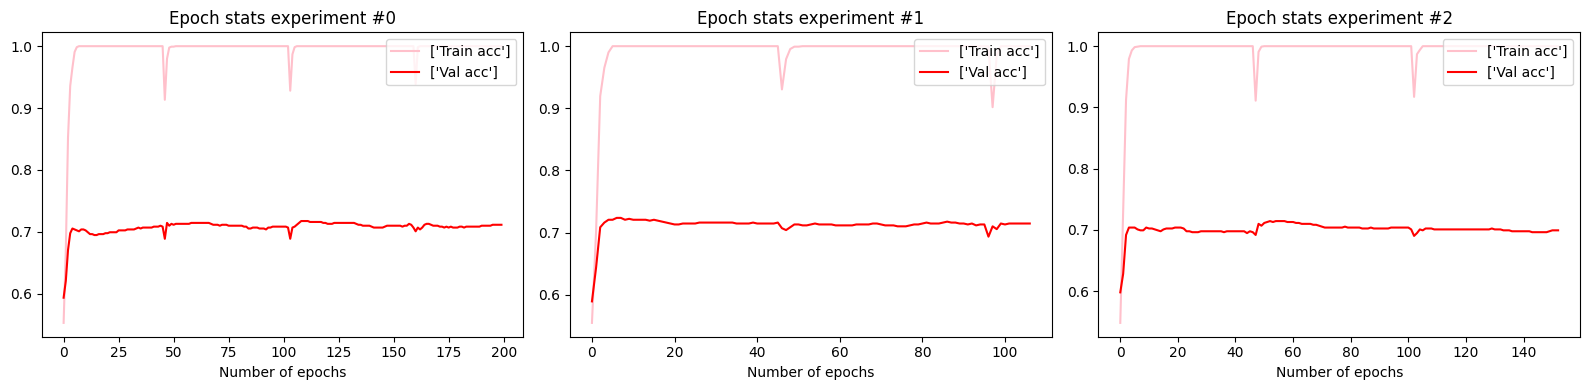

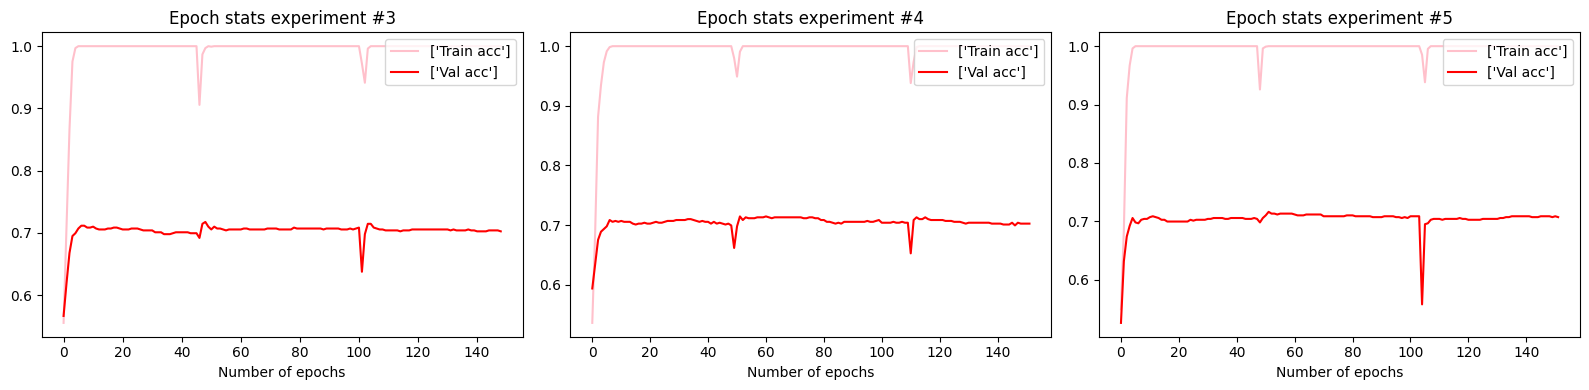

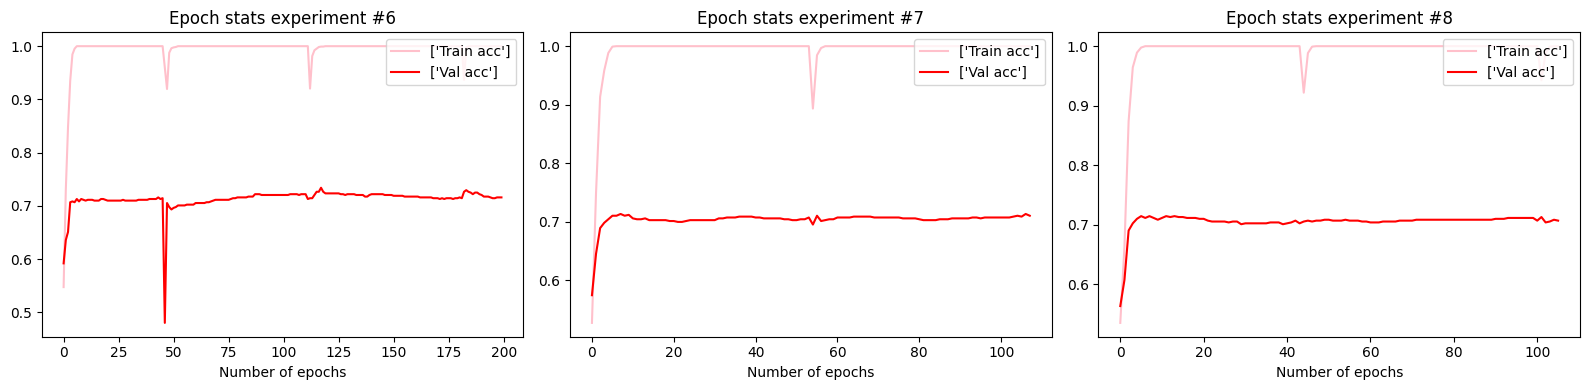

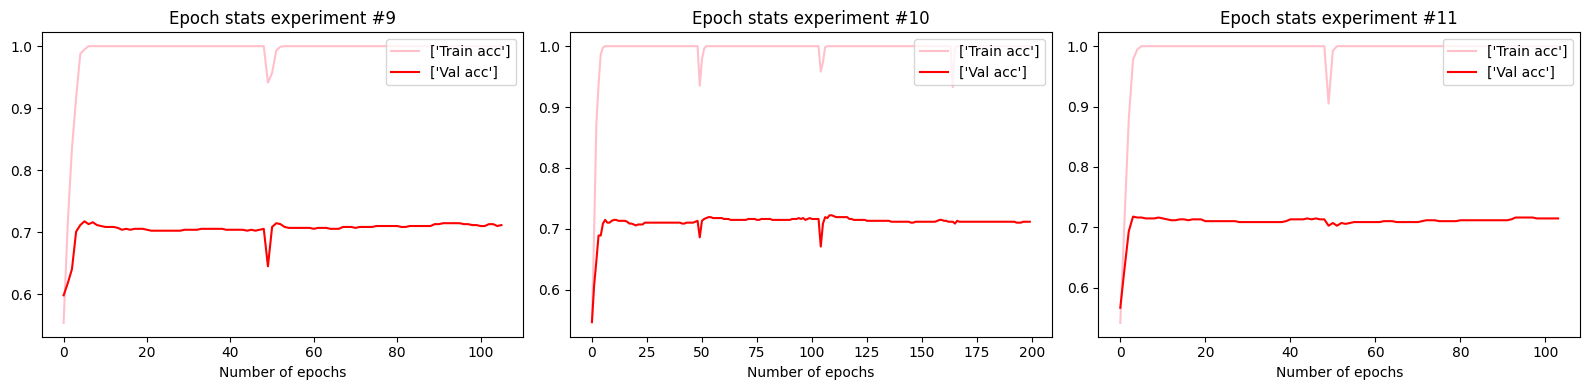

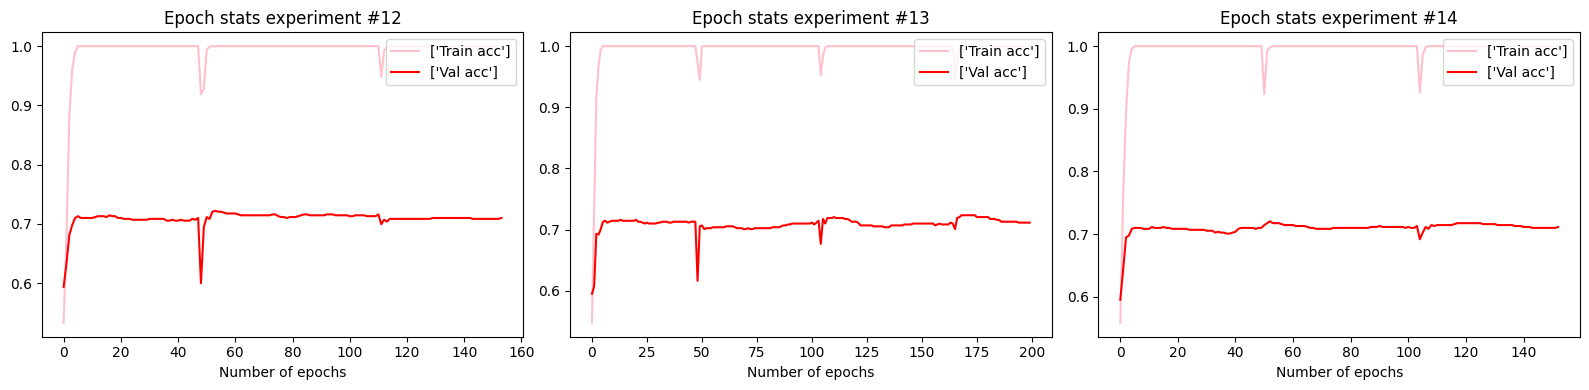

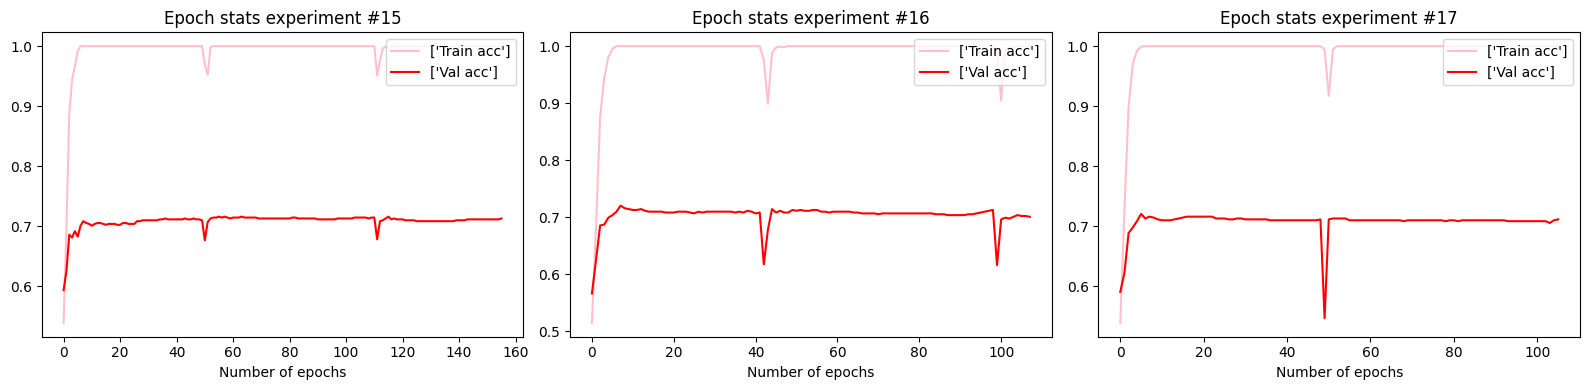

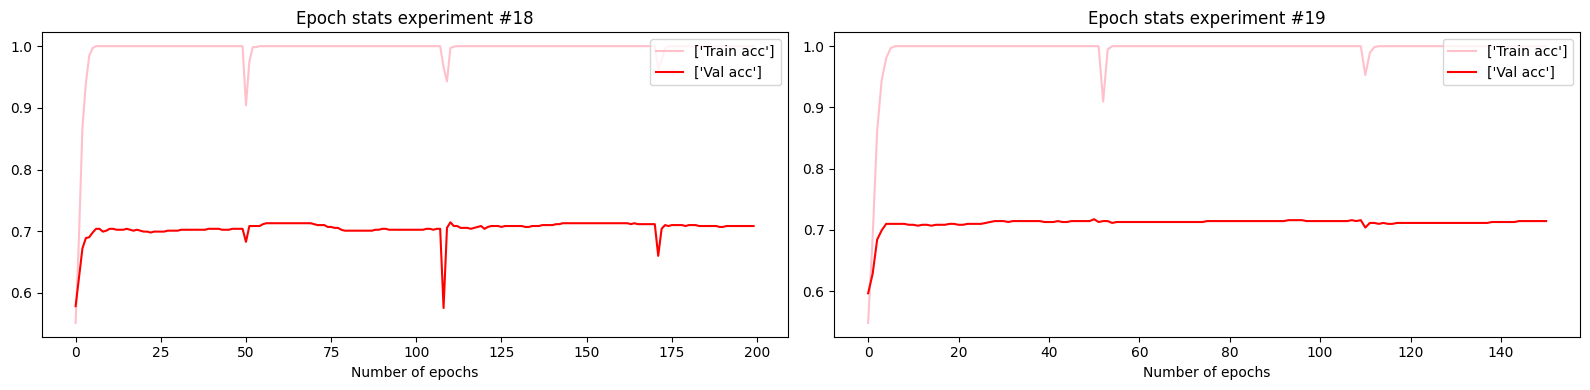

In [37]:
display_epochs_stats(deepset_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### DeepSets V2

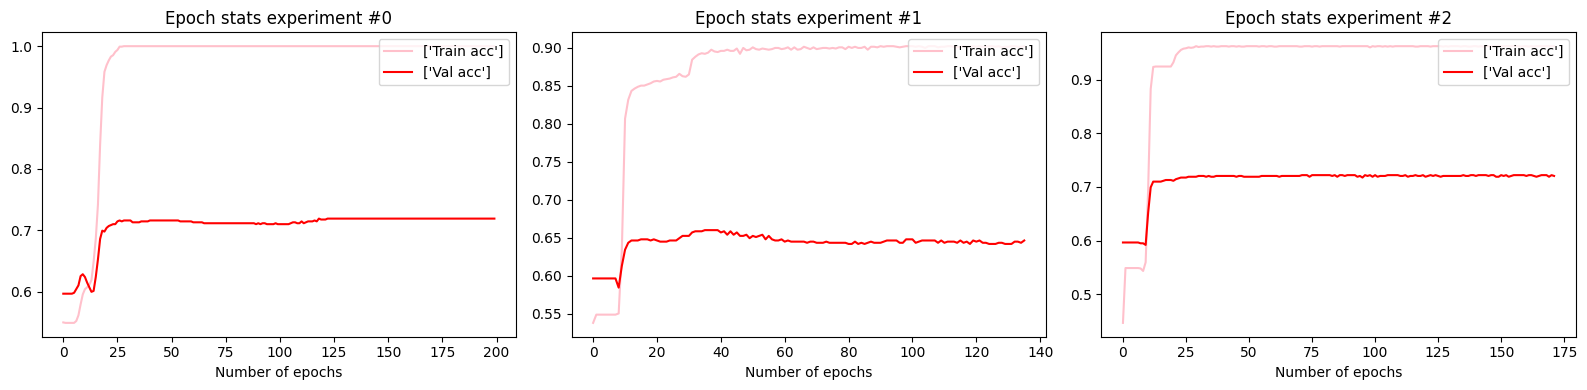

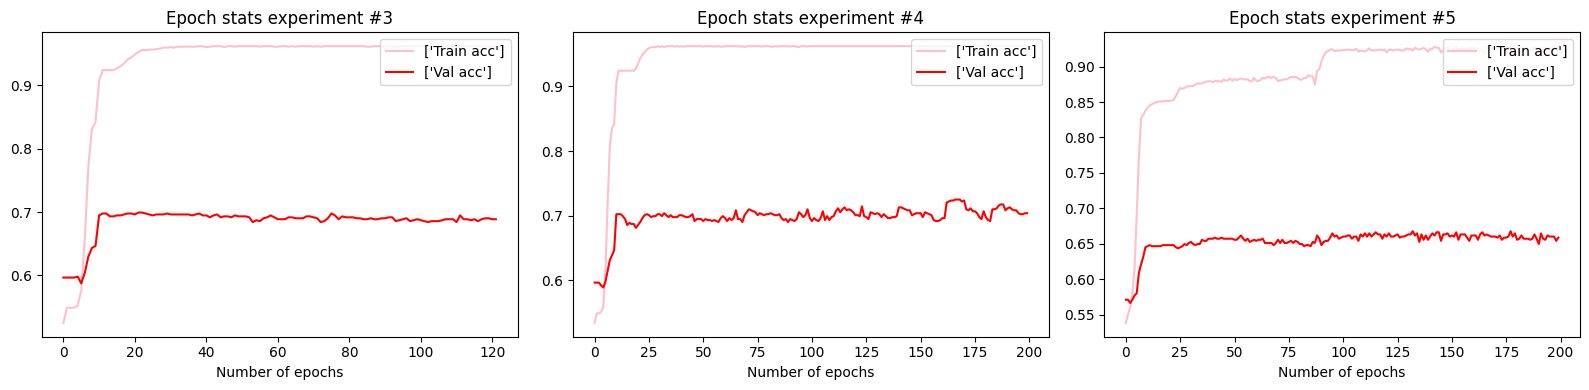

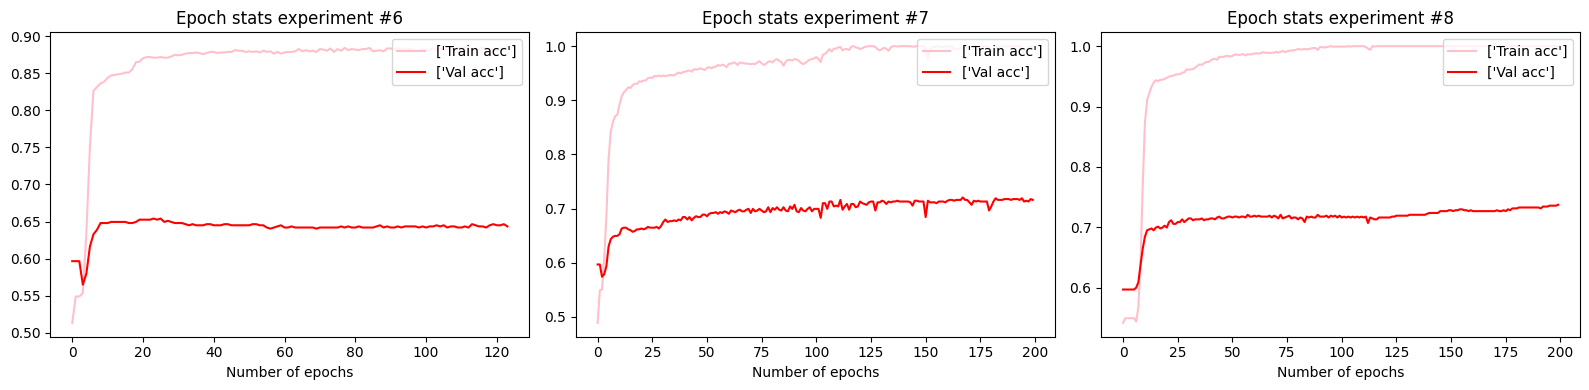

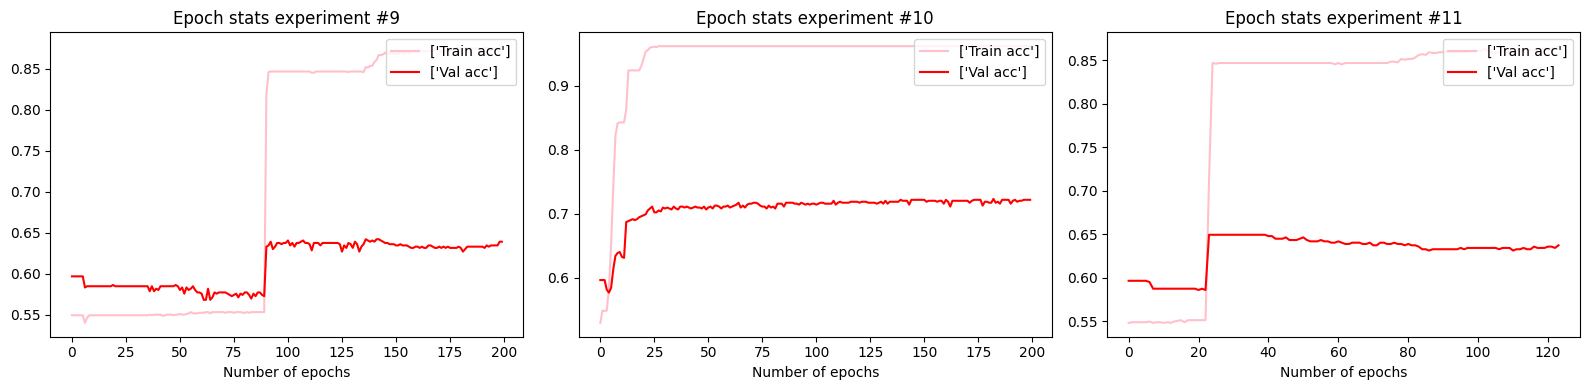

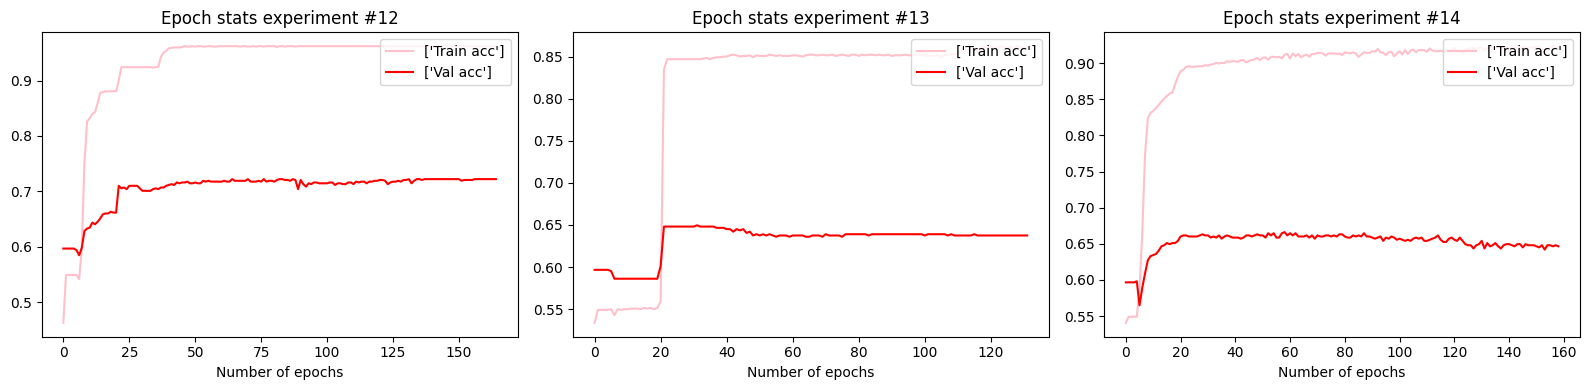

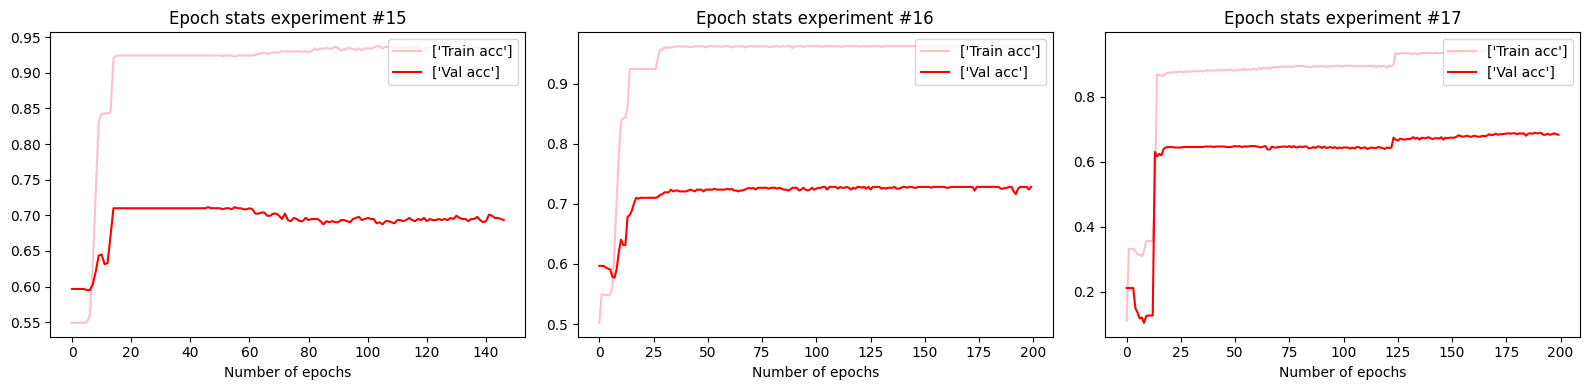

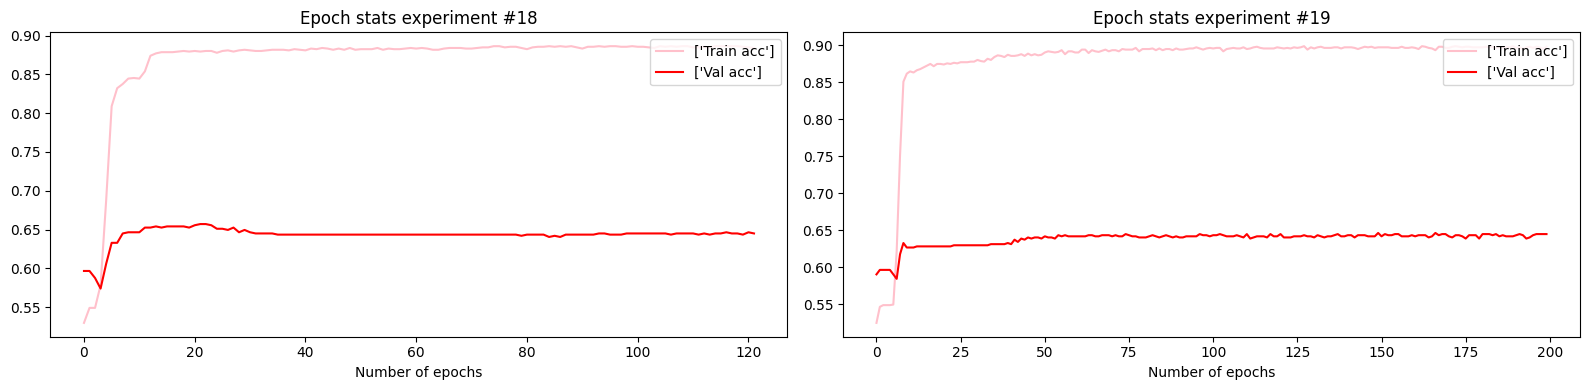

In [38]:
display_epochs_stats(deepsetv2_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### FeedForward

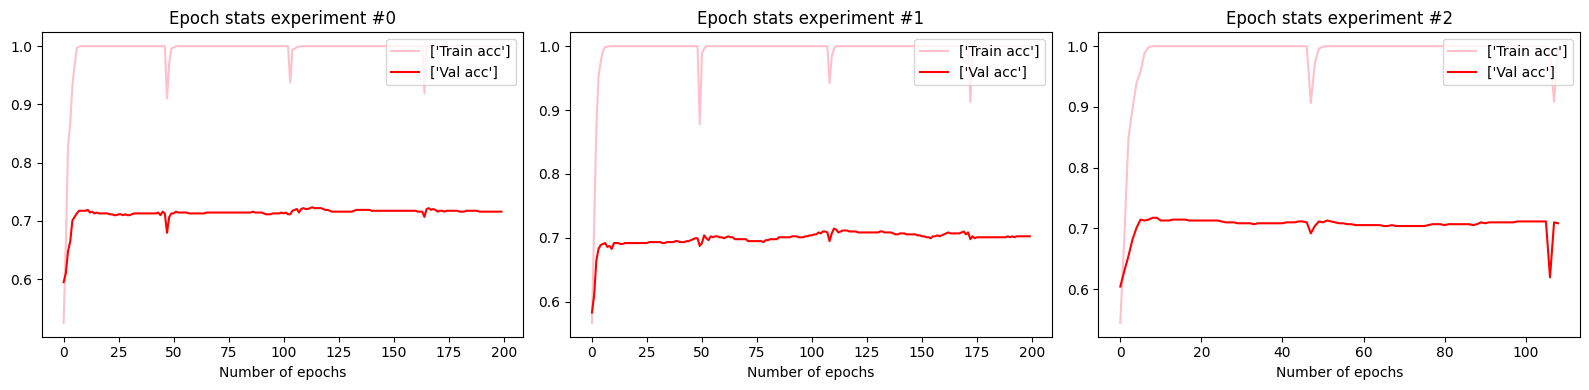

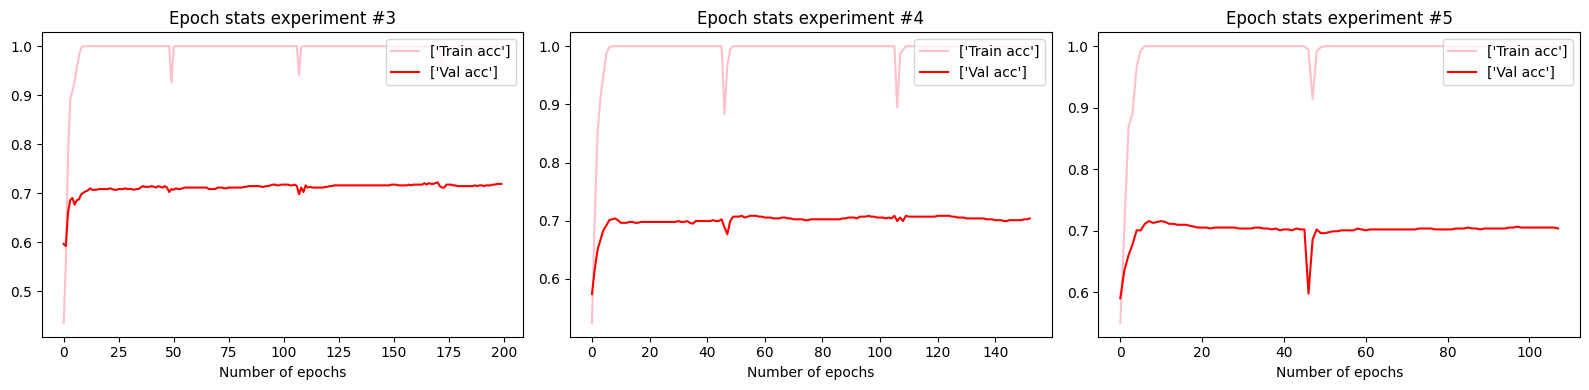

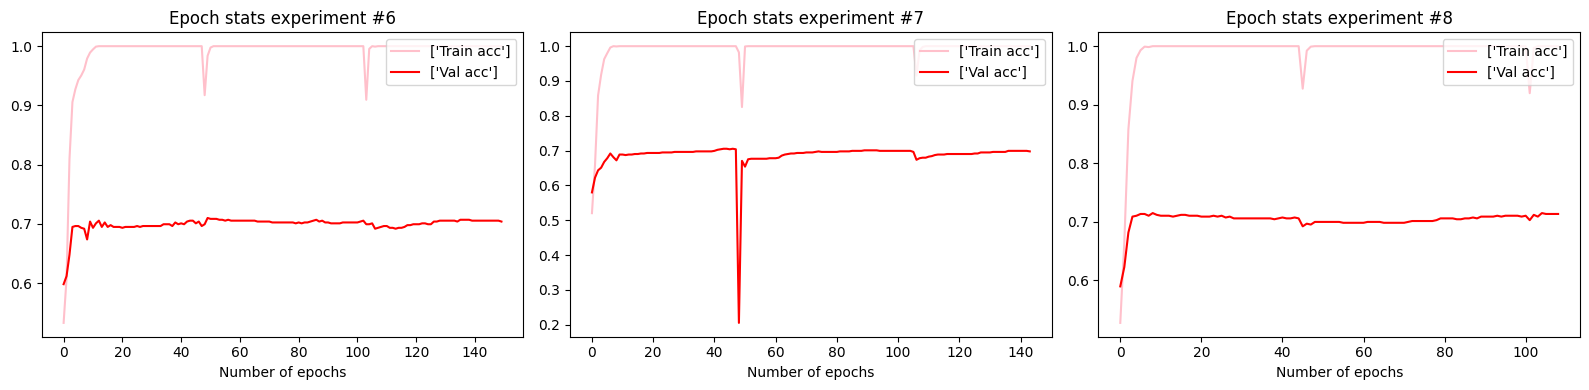

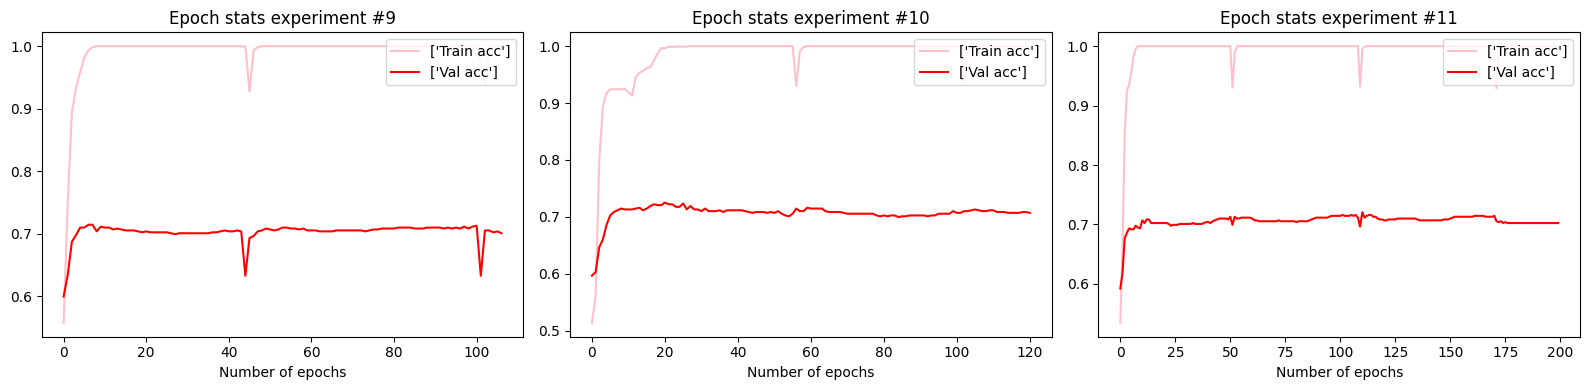

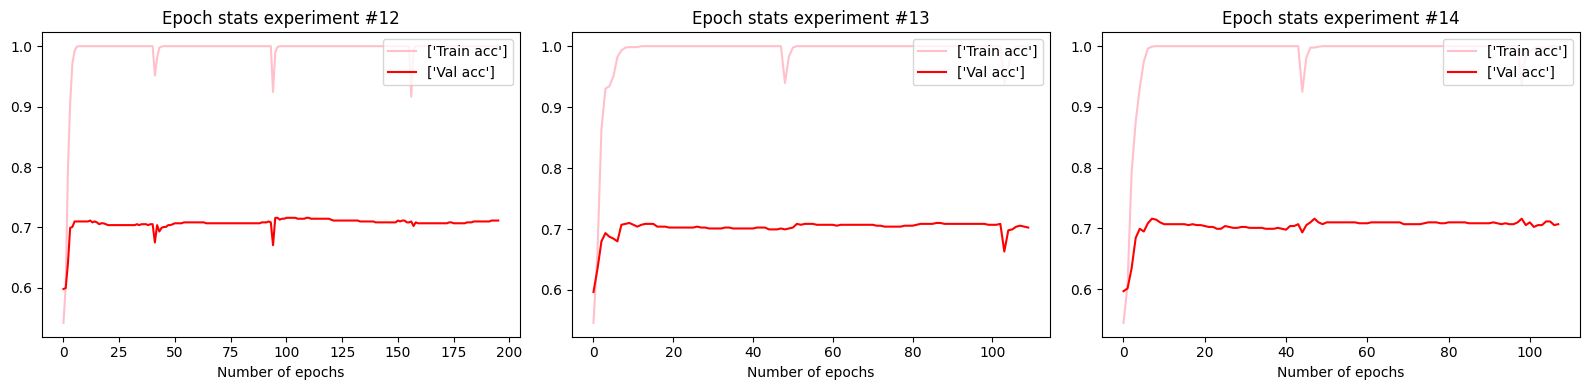

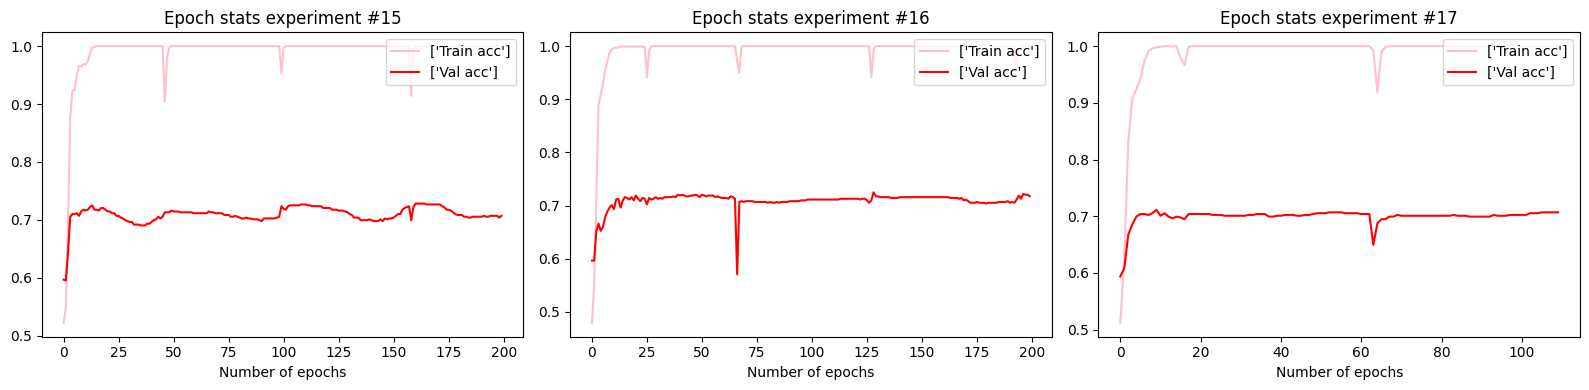

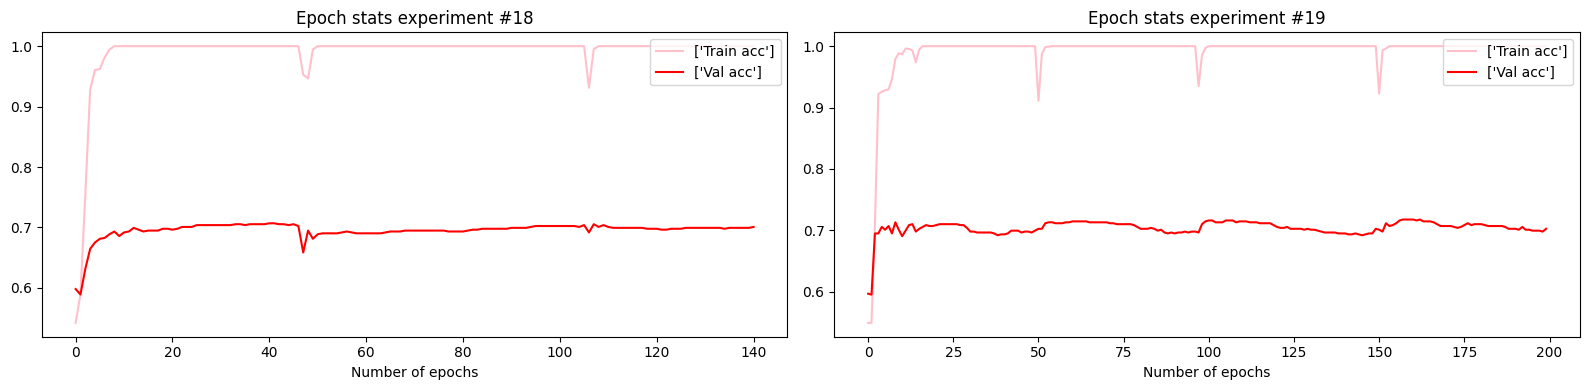

In [39]:
display_epochs_stats(feedforward_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

# Best performing models

In [40]:
best_lstm_model = LSTM_Model(data, 16, 16, 8).to(device)
best_lstm_model.load_state_dict(torch.load('./bestmodels/best_LSTM_model_' + experiment_name))
best_cnn_model = CNN_Model(data, 32, 64, 4, -1,).to(device)
best_cnn_model.load_state_dict(torch.load('./bestmodels/best_CNN_model_' + experiment_name))
best_deepset_model = DEEPSET_Model(data).to(device)
best_deepset_model.load_state_dict(torch.load('./bestmodels/best_DEEPSET_model_' + experiment_name))
best_deepsetv2_model = DEEPSETV2_Model(data).to(device)
best_deepsetv2_model.load_state_dict(torch.load('./bestmodels/best_DEEPSETV2_model_' + experiment_name))
best_feedforward_model = FEEDFORWARD_Model(data).to(device)
best_feedforward_model.load_state_dict(torch.load('./bestmodels/best_FEEDFORWARD_model_' + experiment_name))

RuntimeError: Error(s) in loading state_dict for LSTM_Model:
	size mismatch for densef1_1.weight: copying a param with shape torch.Size([32, 16]) from checkpoint, the shape in current model is torch.Size([16, 16]).
	size mismatch for densef1_1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for densef2_1.weight: copying a param with shape torch.Size([32, 16]) from checkpoint, the shape in current model is torch.Size([16, 16]).
	size mismatch for densef2_1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for densef3_1.weight: copying a param with shape torch.Size([32, 16]) from checkpoint, the shape in current model is torch.Size([16, 16]).
	size mismatch for densef3_1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for densef1_2.weight: copying a param with shape torch.Size([8, 32]) from checkpoint, the shape in current model is torch.Size([8, 16]).
	size mismatch for densef2_2.weight: copying a param with shape torch.Size([8, 32]) from checkpoint, the shape in current model is torch.Size([8, 16]).
	size mismatch for densef3_2.weight: copying a param with shape torch.Size([8, 32]) from checkpoint, the shape in current model is torch.Size([8, 16]).

## Top wrong predictions for best performing CNN model

In [44]:
print_wrong_preds([get_wrong_predictions(best_cnn_model, x_test_cnn, y_test, test_original)], top_k=10)

Top 10 false positives: 

.._..,_,_.__w._u .,..,.d_.r_.,.,_ | label: False | actual prediction: 0.9997254014015198
.,,,_._,_.._w_.u ,_,._,.d,_r._,., | label: False | actual prediction: 0.9996028542518616
.,_.,_._w__u._._ .,,.___d_.r._.,_ | label: False | actual prediction: 0.9995676875114441
,,.,._,,,,__w,_u ,...__.__,,d,_r. | label: False | actual prediction: 0.9995582699775696
.___,_.,..___wu. ,..,...dr,.__,__ | label: False | actual prediction: 0.9995114803314209
__..._w,,u._.,__ .,,,__,.___d..r, | label: False | actual prediction: 0.9994730353355408
,._._,.__,__w,_u ,,_.,_._,d,,r___ | label: False | actual prediction: 0.9994465708732605
_,.,,.,w,_u_.,__ .,,,_..,,__d_.r. | label: False | actual prediction: 0.9993756413459778
,_____.w__u..,,, ,_.,_.,d.,r...__ | label: False | actual prediction: 0.999352753162384
,._._,,_,_w_.u.. ____.,.d,.r._,_, | label: False | actual prediction: 0.9992997646331787

Top 10 false negatives: 





## Top wrong predictions for best performing LSTM model

In [45]:
print_wrong_preds([get_wrong_predictions(best_lstm_model, x_test_lstm, y_test, test_original)], top_k=10)

Top 10 false positives: 

,_,_,_.,..,_,__. ,_,....cr.,,,,., | label: False | actual prediction: 0.7809653878211975
,,____.,,._,,_.. __,..,.,cr,,,,,, | label: False | actual prediction: 0.680822491645813
_._._...._.,,,., _,,.,.c.,r,.,_,, | label: False | actual prediction: 0.6451743841171265

Top 10 false negatives: 

_,,_,.,_._.wu.., ,,.,,,,,,..,,r_. | label: True | actual prediction: 0.29545581340789795
._,.,_._,,,w..u. ,,._,,._.,..,r,, | label: True | actual prediction: 0.30590301752090454
_,.,,_._wu_,,.,. .._.,_..,,..,.r. | label: True | actual prediction: 0.35801976919174194
,_.,.,_w..u,_,_, _.__,,,..,.,r_,_ | label: True | actual prediction: 0.38968828320503235
_.._._,,_,wu.,._ ..,.,,,._,,r,,._ | label: True | actual prediction: 0.4883977174758911
.._,__,...wu,,_. .,__.,..,,,.r__, | label: True | actual prediction: 0.5055970549583435
_,,,,,,,w._u,.__ ,,__..,,_.._.r,. | label: True | actual prediction: 0.507112443447113
._.__,_.,wu,,_., ,,.__,._.,_,_r., | label: True | actual predi

## Top wrong predictions for best performing DeepSets V1 model

In [46]:
print_wrong_preds([get_wrong_predictions(best_deepset_model, x_test_normal, y_test, test_original)], top_k=10)

Top 10 false positives: 

_._,._w._u,..__, __.._.d,,r,,,_., | label: False | actual prediction: 0.9996644258499146
.._..,_,_.__w._u .,..,.d_.r_.,.,_ | label: False | actual prediction: 0.9984999895095825
..,,..,._,w.,u., ___._,d__r,.,.,, | label: False | actual prediction: 0.9969462752342224
..,_.__,_w_,u,., _,,...d..r,,__,. | label: False | actual prediction: 0.9963898062705994
._,_._,,w..u,,._ ,__._,d.,r,.._,, | label: False | actual prediction: 0.9947928786277771
,__.,___,,_w.,u_ .,,_.,d_,r,_,_,. | label: False | actual prediction: 0.9937875270843506
,.__,._,_,,.,wu_ .__,..,cr.,.,__. | label: False | actual prediction: 0.8880898356437683
_,,,.,.._,_.w,,_ .....,,cr.,_._._ | label: False | actual prediction: 0.8721662759780884

Top 10 false negatives: 

,.__,,,wu,,,._,. ,.__._..._r.,.., | label: True | actual prediction: 4.4064152326939166e-10
.__.__,_uw,_.,.. ,.,.,.._,.r._.__ | label: True | actual prediction: 3.863041886376095e-09
,__,,,__uw__.,_, .___,,_,,.,r,._, | label: True | ac

## Top wrong predictions for best performing DeepSets V2 model

In [47]:
print_wrong_preds([get_wrong_predictions(best_deepsetv2_model, x_test_normal, y_test, test_original)], top_k=10)

Top 10 false positives: 


Top 10 false negatives: 

__,.,._.u_.w.,__ _,.,_,,_.,_,.r,. | label: True | actual prediction: 0.5
,___..,_wu._._,_ ,,._,..,_.__,r,_ | label: True | actual prediction: 0.5
,,_,_..._,,,w,._ _,._,,_,_.,...dr | label: True | actual prediction: 0.5
,.__,,_,,_w,,,,, ,,,._._dr,,.,... | label: True | actual prediction: 0.5
__,__,.,,uw,,_._ _...___,_._,.dr. | label: True | actual prediction: 0.5
..,,.,..,_,,.,_. .,.,.,_..r,__,,_ | label: True | actual prediction: 0.5
.,,._,.w.,_.,.,. ,_,._,,r,.,._,., | label: True | actual prediction: 0.5
_...,,__....__.. ..,_,.,,,dr,,,__ | label: True | actual prediction: 0.5
,,,._,_,...__uw. .,,._,___.,,,,r. | label: True | actual prediction: 0.5
_,_,__.,uw,..._. ,.__,.._,_..dr.. | label: True | actual prediction: 0.5




## Top wrong predictions for best performing Feedforward model

In [48]:
print_wrong_preds([get_wrong_predictions(best_feedforward_model, x_test_normal, y_test, test_original)], top_k=10)

Top 10 false positives: 

_.,_....,_,_.,,. ._,,,,,cr__,._.. | label: False | actual prediction: 0.9861645102500916
.__,,._,_,wu.,,. ,,_._,,dr,__,,,, | label: False | actual prediction: 0.9861645102500916
_._,._w._u,..__, __.._.d,,r,,,_., | label: False | actual prediction: 0.9861645102500916
..,,..,._,w.,u., ___._,d__r,.,.,, | label: False | actual prediction: 0.9861645102500916
_._.._,..w,,,_,. .,_,.._cr__,__,. | label: False | actual prediction: 0.9861645102500916
..,_.__,_w_,u,., _,,...d..r,,__,. | label: False | actual prediction: 0.9861645102500916
.,_.._..wu.,.___ ,,__,__cr_,__,_. | label: False | actual prediction: 0.9861645102500916
.._,.,,.,uw.__,_ _,_..,.cr__,_,_. | label: False | actual prediction: 0.9861645102500916
,_.,,.._uw,._,,_ .,,,__,cr,,__._. | label: False | actual prediction: 0.9861645102500916
.__.,,__,.uw.,._ ,___.,.cr._..,_, | label: False | actual prediction: 0.9861645102500916

Top 10 false negatives: 

,.__,,,wu,,,._,. ,.__._..._r.,.., | label: True | actual 

# Saving Notebook State

In [49]:
import dill
dill.dump_session('notebook_env_' + experiment_name + '.db')

# Loading Notebook State

In [50]:
import dill
experiment_name = "f2_f4_redo"
# dill.load_session('notebook_env_' + experiment_name + '.db')